In [1]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from env_paths import *
from global_variables import *

In [21]:
def denormalize(predictions):
    for col in INPUT_COLS:
        min, max = MIN_MAX_COLS_VALUES[col]
        predictions[col] = predictions[col] * (max - min) + min

    return predictions

def normalize(df):
    # Normalizacion de cada columna empleando (xi – minimo(x)) / (maximo(x) – minimo(x))
    for col, (min, max) in MIN_MAX_COLS_VALUES.items():
        df[col]=(df[col]-min)/(max-min)

def max_error(targets, predictions):
    for col in INPUT_COLS:
        max_value = 0
        for target, prediction in zip(targets, predictions):
            max_value = max(max_value, max(abs(target[col] - prediction[col])))
        print(col, max_value)

def get_predictions(model, X_test):
    predictions = []
    for prediction_window in model.predict(X_test):
        prediction = pd.DataFrame(data=prediction_window, columns=INPUT_COLS)
        prediction = denormalize(prediction)
        predictions.append(prediction)
    return predictions

def plot_results(targets, predictions, data_limits):
    for sensor, (lim_inf, lim_sup) in enumerate(zip(data_limits, data_limits[1:]), 1):
        for col in INPUT_COLS:
            target_stream = np.array([])
            prediction_stream = np.array([])
            
            for target, prediction in zip(targets[lim_inf:lim_sup], predictions[lim_inf:lim_sup]):
                target_stream = np.concatenate([target_stream, target[col].to_numpy()])
                prediction_stream = np.concatenate([prediction_stream, prediction[col].to_numpy()])
            
            
            plt.figure(num="Sensor " + str(sensor))
            plt.title("Sensor " + str(sensor))
            plt.scatter(range(len(target_stream)), target_stream, linewidths=0.5, s=0.5)
            plt.scatter(range(len(prediction_stream)), prediction_stream, linewidths=0.5, s=0.5)
            plt.legend(["Valor real", "Prediccion"])
            plt.xlabel(col)
            plt.show()

In [3]:
# files = os.listdir(CLASSIFIED_SENSOR_PATH)
df = pd.read_csv(INTEGRATED_DATA_PATH)
df['ts'] = pd.to_datetime(df['ts'], unit="ns")

normalize(df)
df.shape

(60489, 8)

In [4]:
learning_rate = 0.01 # Ratio de aprendizaje
batch_size = 256 # Tamanno del conjunto de datos que se introducen en bloque en entrenamiento
epochs = 100 # Epocas de entrenamiento de la RNA
window_size_inputs = 6 # Tamanno de la ventana de datos previos para predecir los posteriores
window_size_targets = 2 # Tamanno de la ventana de datos posteriores (datos a predecir)
train_frac = 0.75 # Fraccion de datos de entrenamiento
val_frac = 0.15 # Fraccion de datos de validacion, el porcentaje restante se dedica a test

def get_optimizer():
    return kr.optimizers.Adam(learning_rate=learning_rate)

def scheduler(epoch, lr):
    return lr if epoch < 50 else lr * tf.math.exp(-0.1) 

def get_scheduler():
    return kr.callbacks.LearningRateScheduler(scheduler)


In [5]:
X_train, y_train = np.array([]), np.array([]) # Cjto de entrenamiento
X_val, y_val = np.array([]), np.array([]) # Cjto de validacion
X_test, y_test = np.array([]), np.array([]) # Cjto de test

data_limits = [0] # Almacena el tamanno de los datos de los sensores para poder graficarlos posteriormente 

sensor_group = df.groupby('sensor')
for _,sensor in sensor_group:
    X = [] # Inputs
    y = [] # Targets
    
    rolling_win = sensor.groupby(pd.Grouper(freq="1H", key="ts"))
    data_windows = [] # Ventana de datos para evitar los saltos temporales
    data_window = []

    # Separamos cada ventana de datos para poder crear el conjunto de datos de entrenamiento
    for _, group in rolling_win: 
        if len(group) == 0 and len(data_window) > 0:
            data_windows.append(data_window)
            data_window = []
        if len(group) > 0:
            data_window.append(group[INPUT_COLS].to_numpy()[0])
    data_windows.append(data_window)


    for data_window in data_windows:
        # En cada ventana de datos comprobamos si hay datos suficientes para la prediccion 
        # temporal, sino continuamos con la siguiente ventana
        if(len(data_window) < window_size_inputs + window_size_targets):
            continue
        # Por cada ventana la recorremos creando una subventana deslizante obteniendo 
        # los inputs de la RNA y el target correspondiente.
        for i in range(len(data_window) - (window_size_inputs + window_size_targets)):
            X.append([a for a in data_window[i : i + window_size_inputs]])
            y.append([a for a in data_window[i + window_size_inputs : i + window_size_inputs + window_size_targets]])
    
    X = np.array(X)
    y = np.array(y)

    # Dividimos el conjunto de datos de cada sensor en entrenamiento, validacion y test.
    train_lim = int(len(X) * train_frac)
    val_lim = train_lim + int(len(X) * val_frac)
    
    # Si el tamanno del conjunto de entrenamiento es 0 es porque todavia no hay datos
    if len(X_train) == 0:
        X_train, y_train = X[:train_lim], y[:train_lim]
        X_val, y_val = X[train_lim : val_lim], y[train_lim : val_lim]
        X_test, y_test = X[val_lim:], y[val_lim:]
        continue

    X_train, y_train = np.concatenate((X_train, X[:train_lim])), np.concatenate((y_train, y[:train_lim]))
    X_val, y_val = np.concatenate((X_val, X[train_lim : val_lim])), np.concatenate((y_val, y[train_lim : val_lim]))

    data_limits.append(len(y_test))

    X_test, y_test = np.concatenate((X_test, X[val_lim:])), np.concatenate((y_test, y[val_lim:]))
data_limits.append(len(y_test))


# GRU

In [6]:
inputs = layers.Input(shape=X_train.shape[1:])
modelGRU = layers.GRU(32, return_sequences=True)(inputs)
modelGRU = layers.GRU(16, return_sequences=True)(modelGRU)
modelGRU = layers.GRU(8)(modelGRU)
modelGRU = layers.Dense(y.shape[1] * y.shape[2])(modelGRU)
outputs = layers.Reshape((y.shape[1], y.shape[2]))(modelGRU)

modelGRU = kr.Model(inputs=inputs, outputs=outputs)
# ch_callback = kr.callbacks.ModelCheckpoint(filepath="./tmp/checkpoint", monitor="val_loss", save_best_only=True, mode="min", verbose=)
modelGRU.compile(loss="mse", optimizer=get_optimizer())
modelGRU.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 6)]            0         
                                                                 
 gru (GRU)                   (None, 6, 32)             3840      
                                                                 
 gru_1 (GRU)                 (None, 6, 16)             2400      
                                                                 
 gru_2 (GRU)                 (None, 8)                 624       
                                                                 
 dense (Dense)               (None, 12)                108       
                                                                 
 reshape (Reshape)           (None, 2, 6)              0         
                                                                 
Total params: 6,972
Trainable params: 6,972
Non-trainable par

In [7]:
# Entrenamiento de la RNA
history = modelGRU.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[get_scheduler()], workers=10)

Epoch 1/100
176/176 [==============================] - 10s 20ms/step - loss: 0.0127 - val_loss: 8.7200e-04 - lr: 0.0100
Epoch 2/100
176/176 [==============================] - 2s 13ms/step - loss: 4.2628e-04 - val_loss: 3.4593e-04 - lr: 0.0100
Epoch 3/100
176/176 [==============================] - 2s 14ms/step - loss: 2.2244e-04 - val_loss: 2.3808e-04 - lr: 0.0100
Epoch 4/100
176/176 [==============================] - 3s 14ms/step - loss: 1.8105e-04 - val_loss: 1.9568e-04 - lr: 0.0100
Epoch 5/100
176/176 [==============================] - 3s 14ms/step - loss: 1.4209e-04 - val_loss: 1.8365e-04 - lr: 0.0100
Epoch 6/100
176/176 [==============================] - 2s 14ms/step - loss: 1.1607e-04 - val_loss: 1.3341e-04 - lr: 0.0100
Epoch 7/100
176/176 [==============================] - 3s 14ms/step - loss: 7.5852e-05 - val_loss: 6.9349e-05 - lr: 0.0100
Epoch 8/100
176/176 [==============================] - 3s 17ms/step - loss: 6.4940e-05 - val_loss: 5.7561e-05 - lr: 0.0100
Epoch 9/100
176/176

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

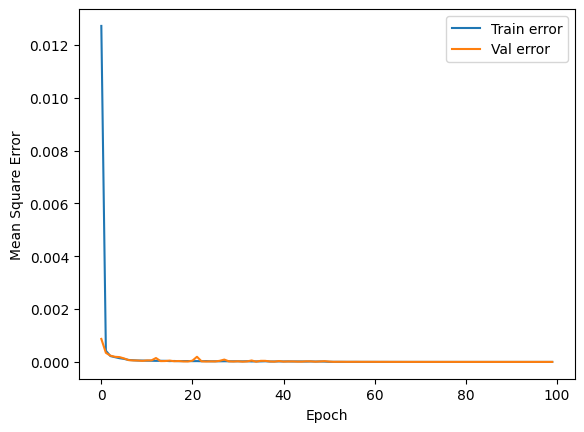

In [9]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [10]:
predictions = []
targets = []

for test_target in y_test:
    target = pd.DataFrame(data=test_target, columns=INPUT_COLS)
    target = denormalize(target)
    targets.append(target)

predictions = get_predictions(modelGRU, X_test)

188/188 [==============================] - 2s 3ms/step


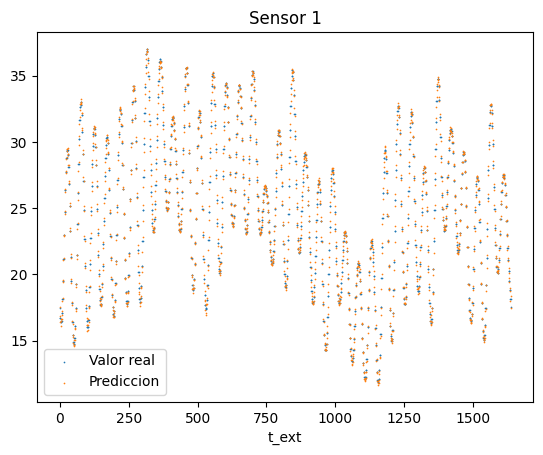

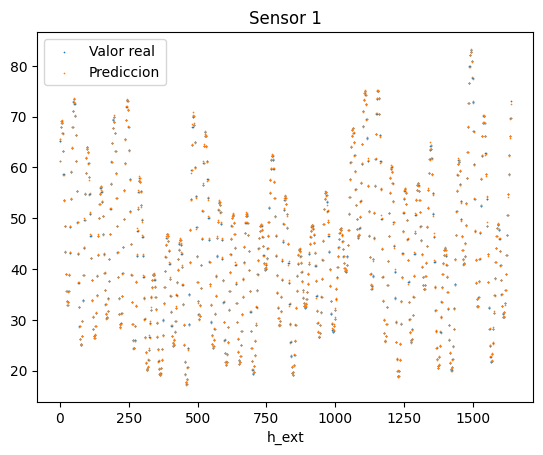

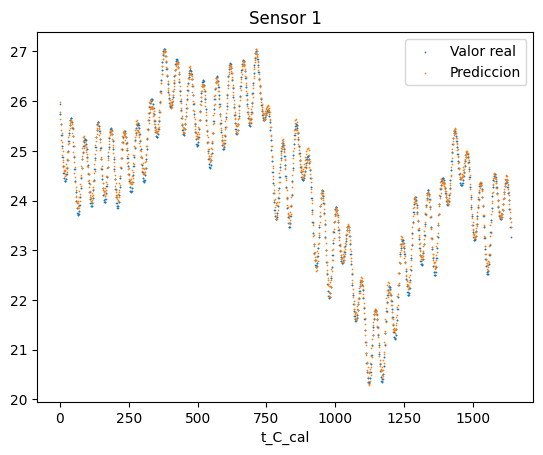

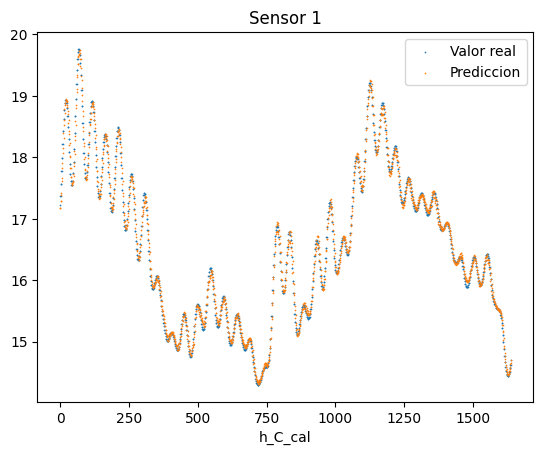

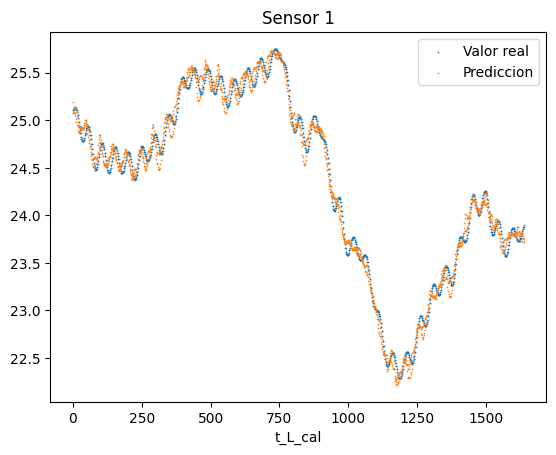

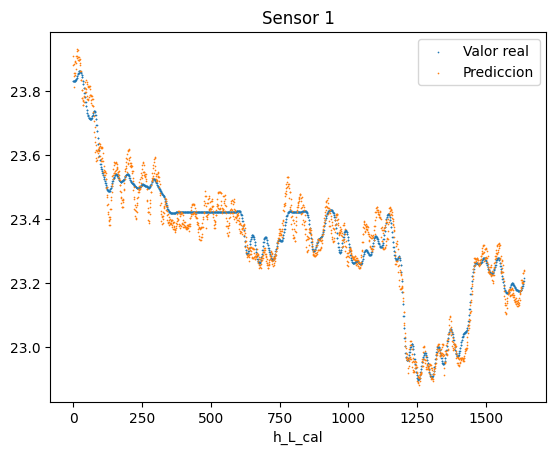

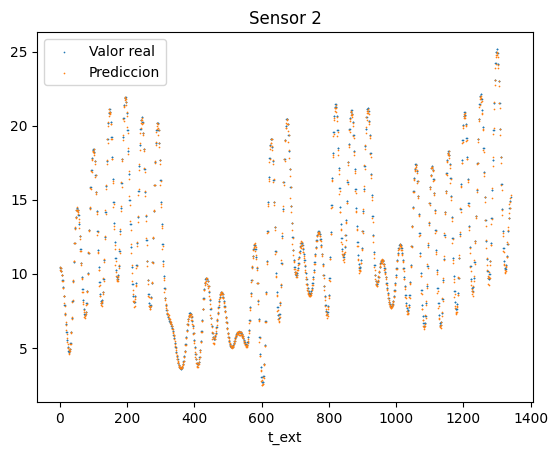

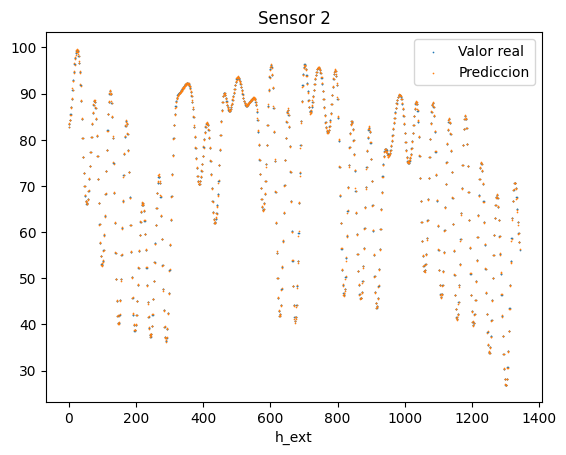

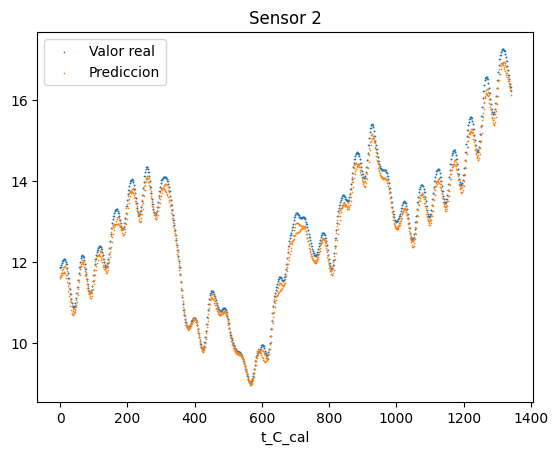

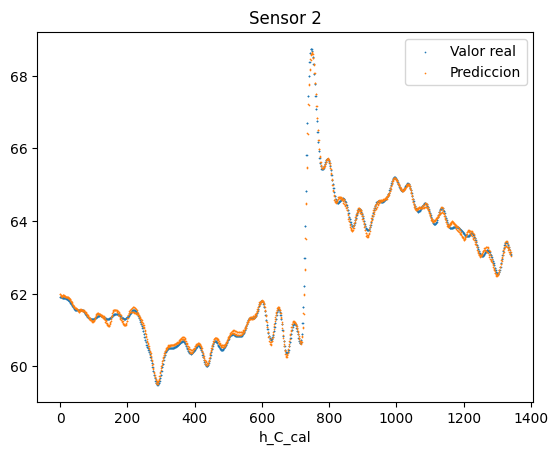

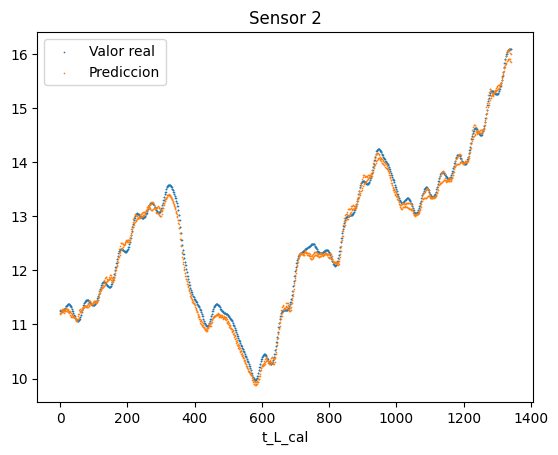

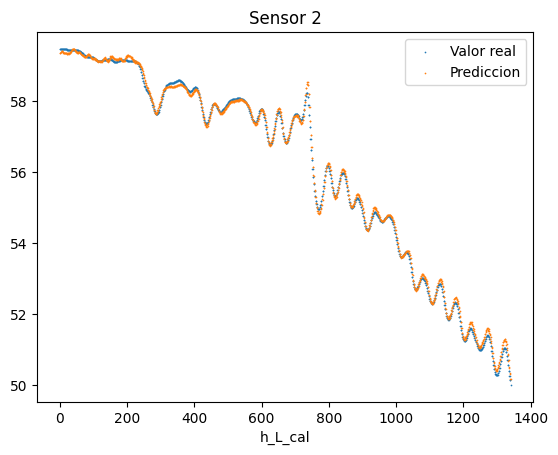

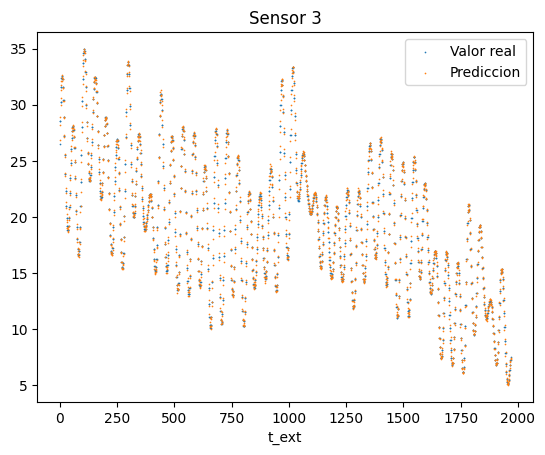

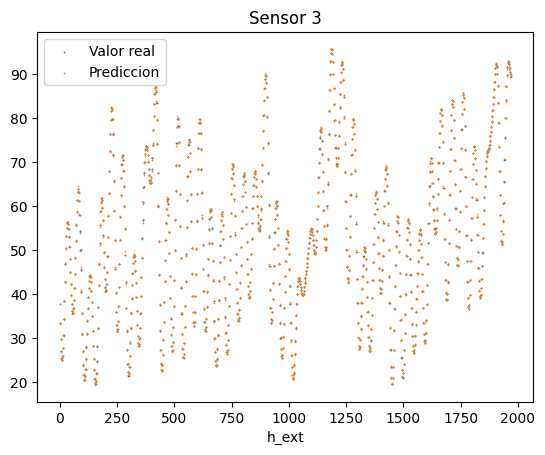

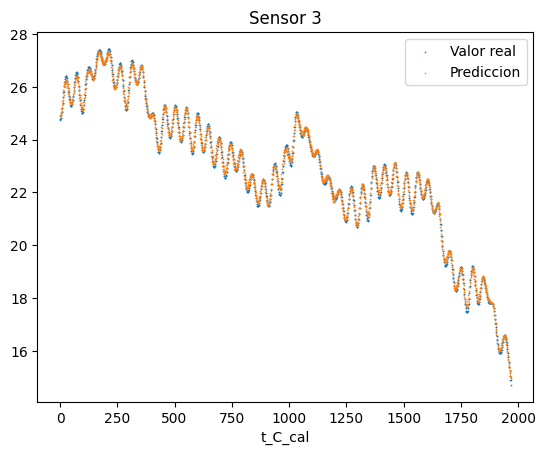

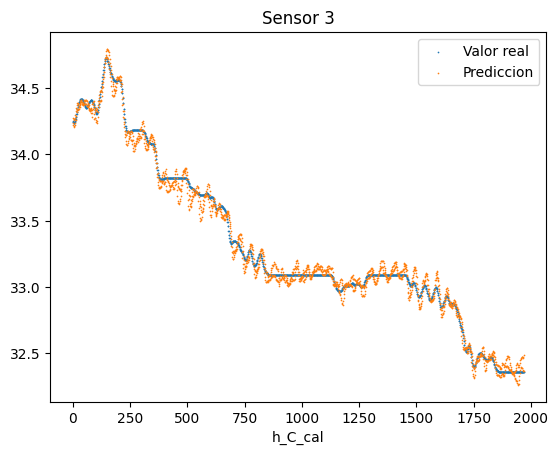

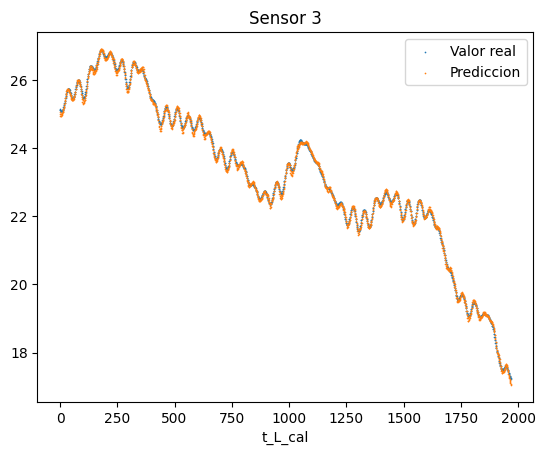

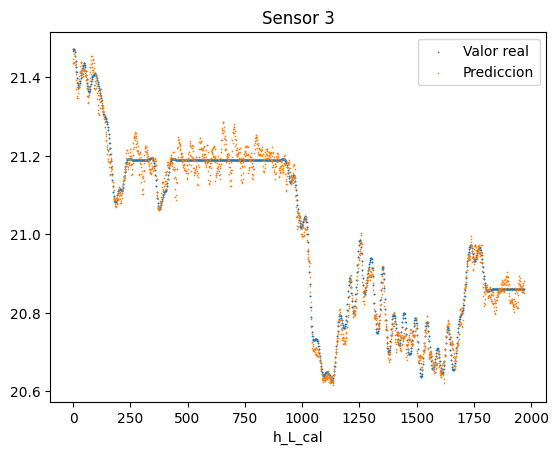

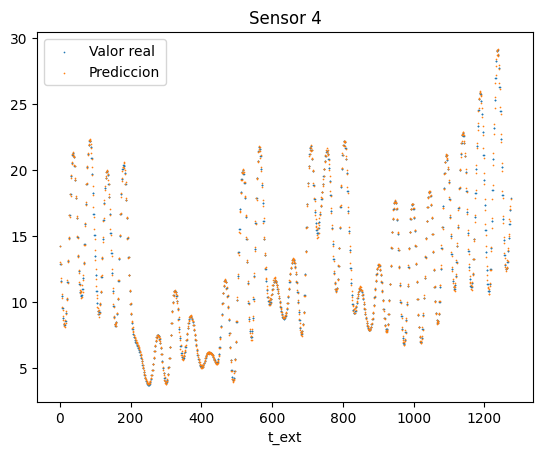

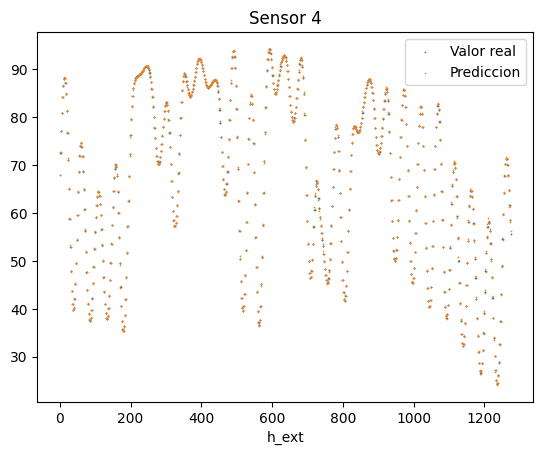

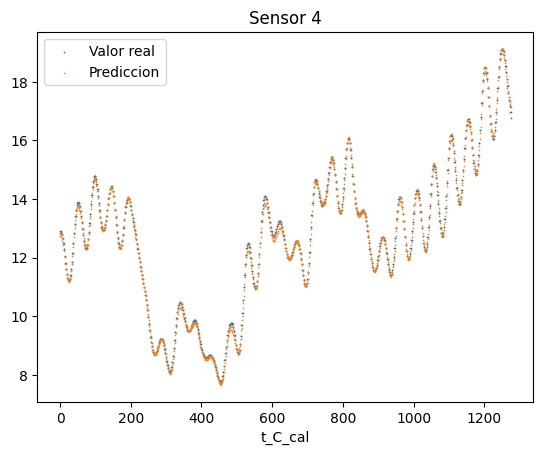

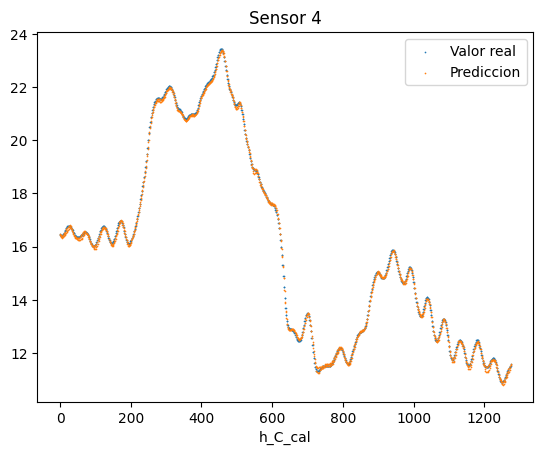

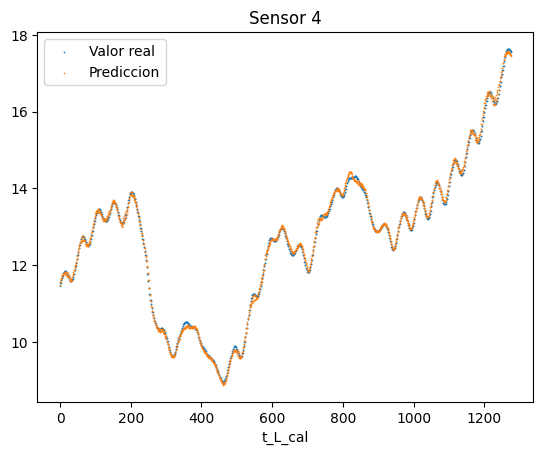

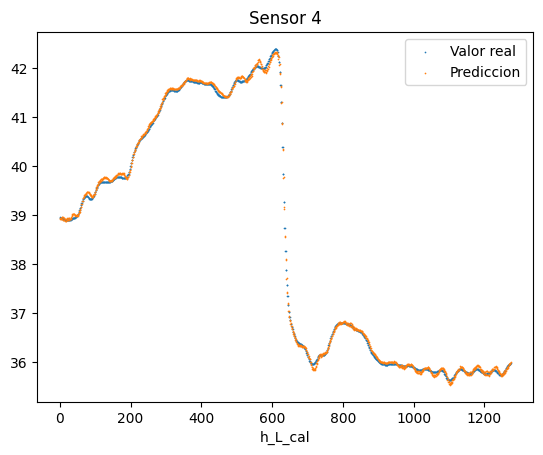

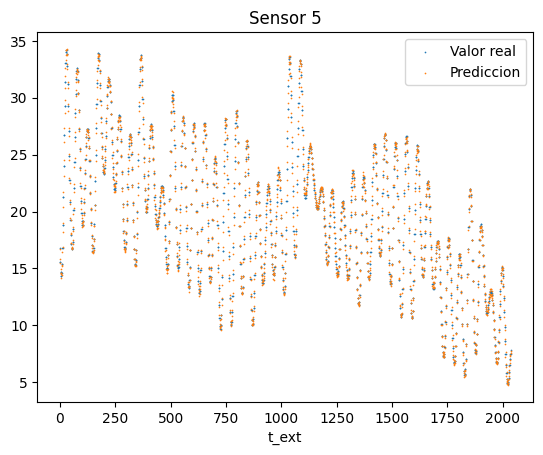

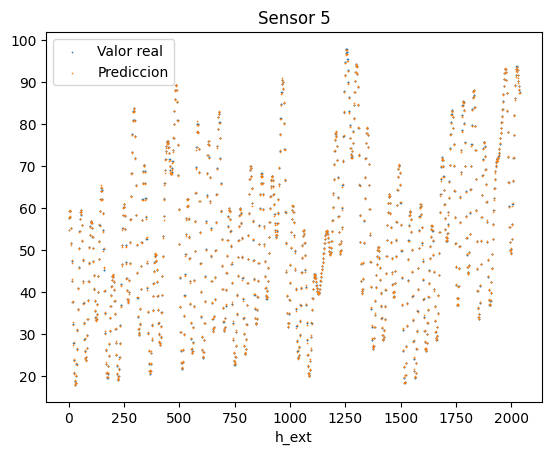

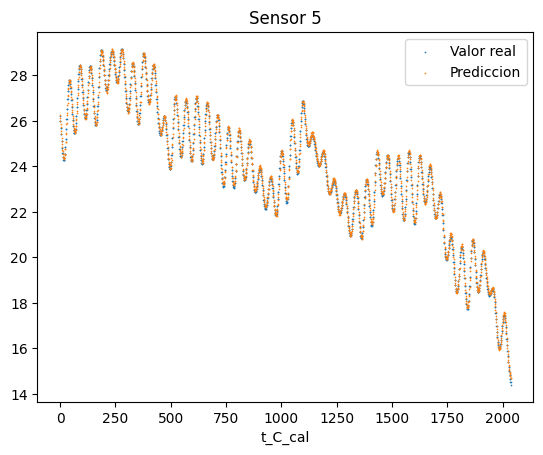

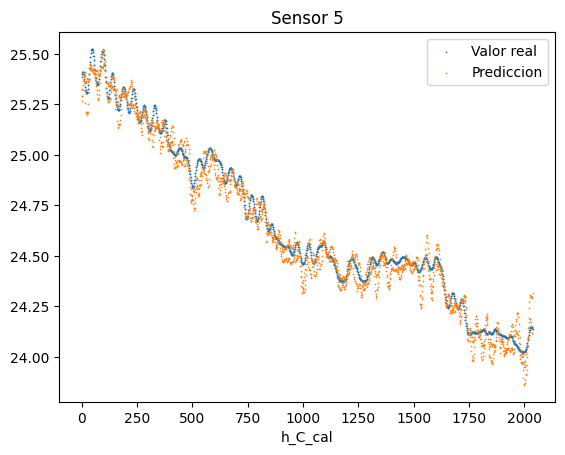

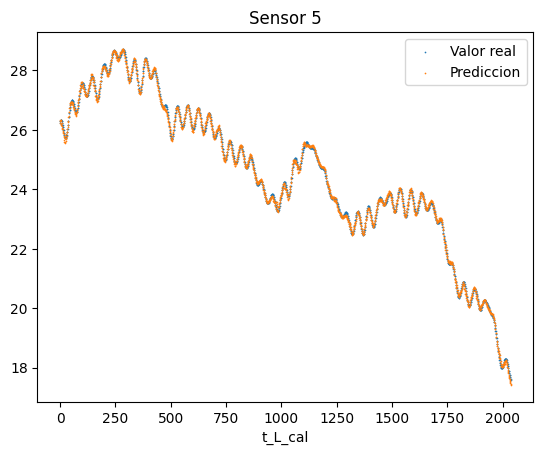

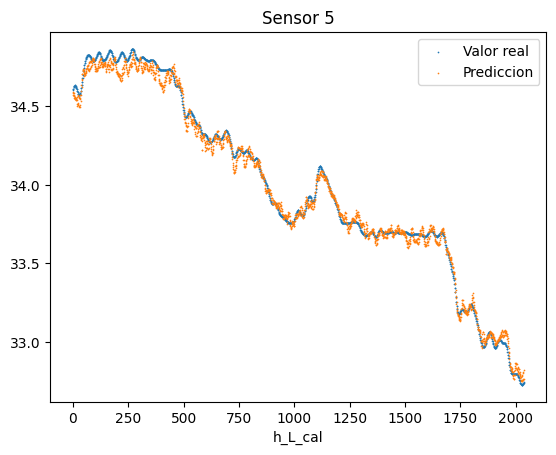

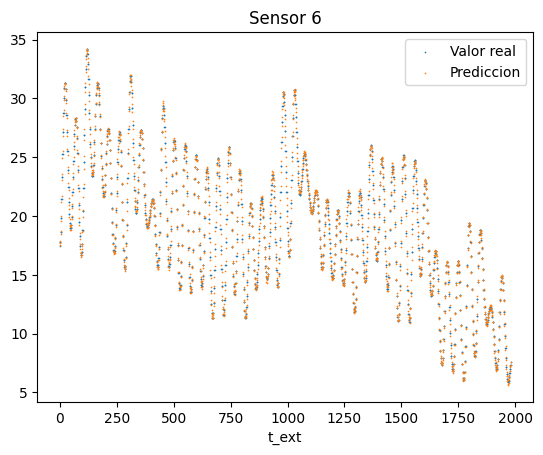

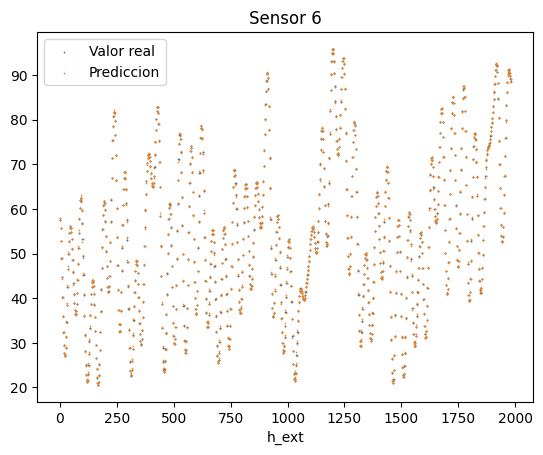

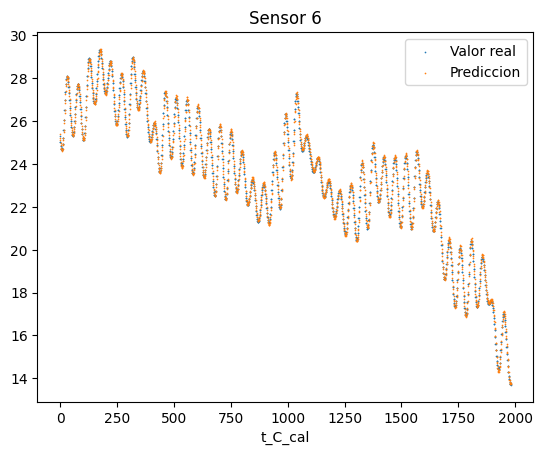

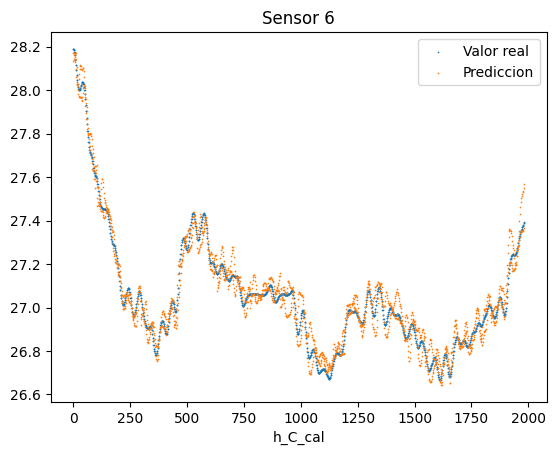

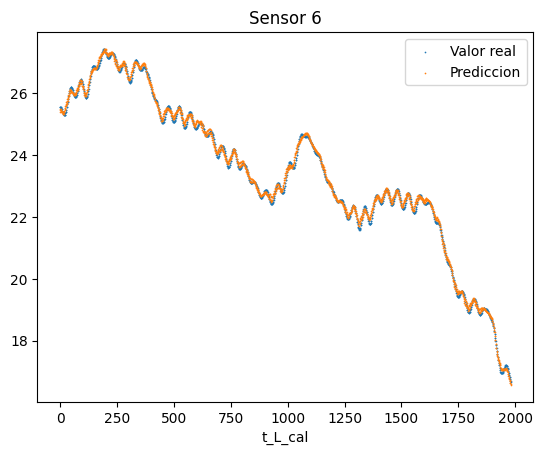

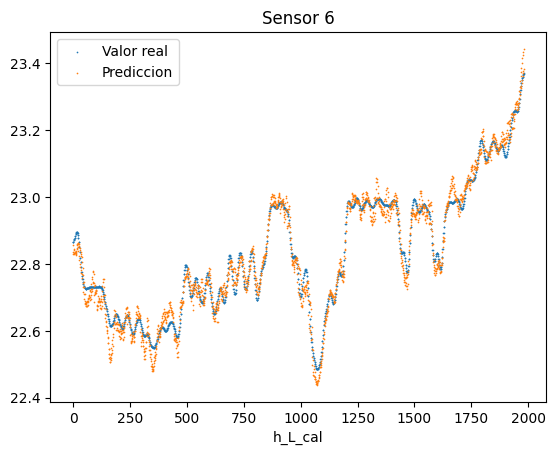

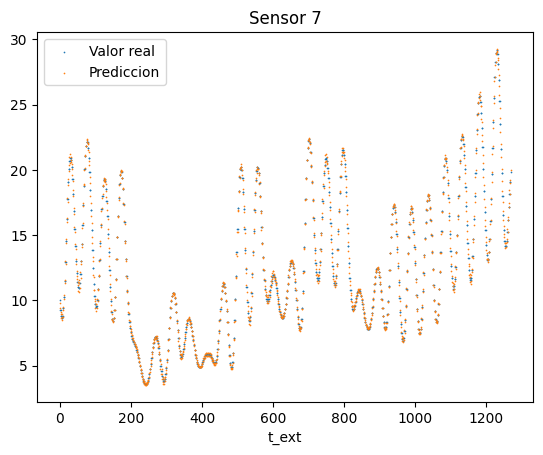

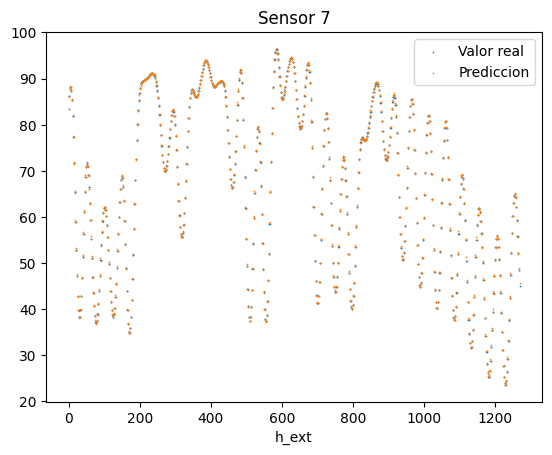

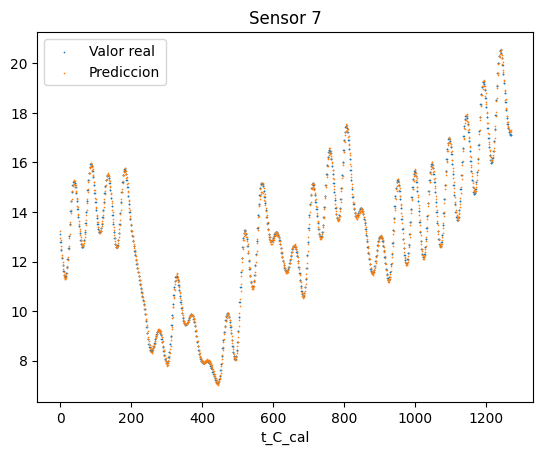

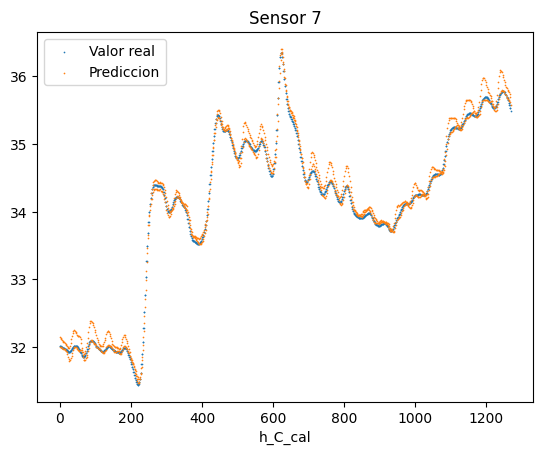

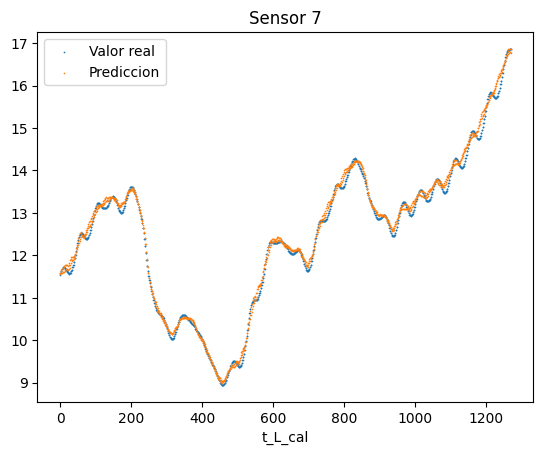

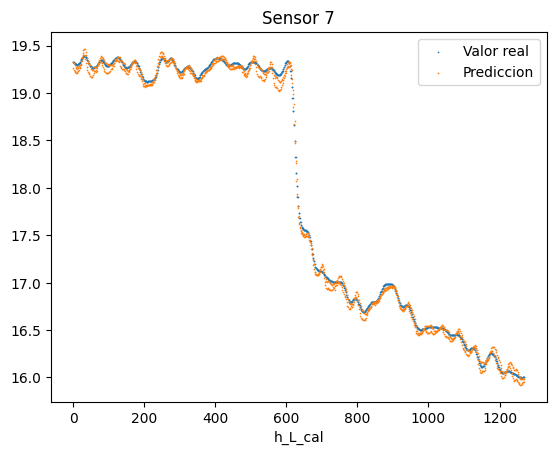

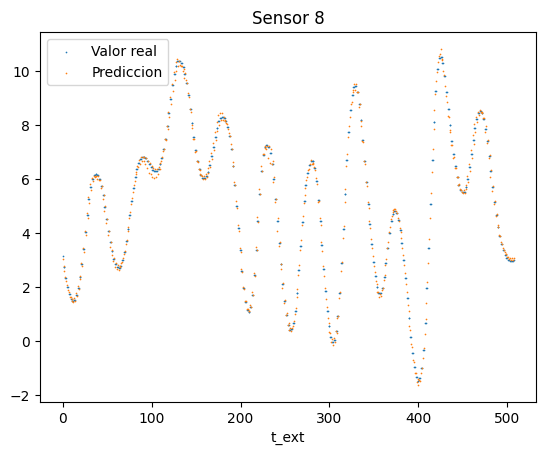

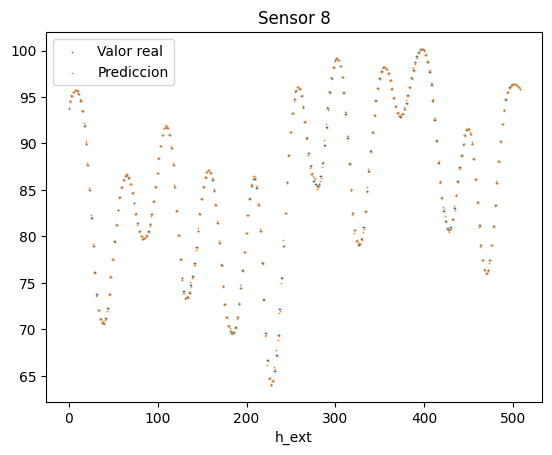

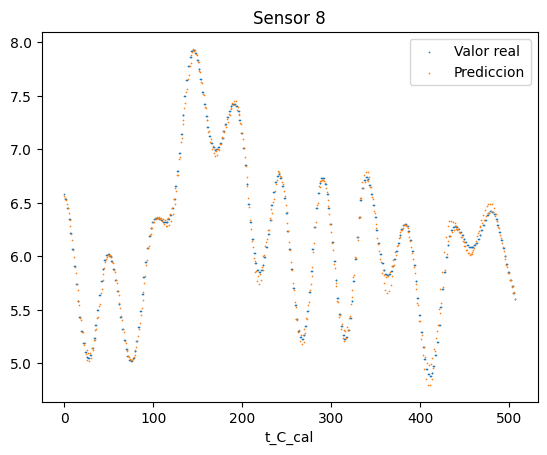

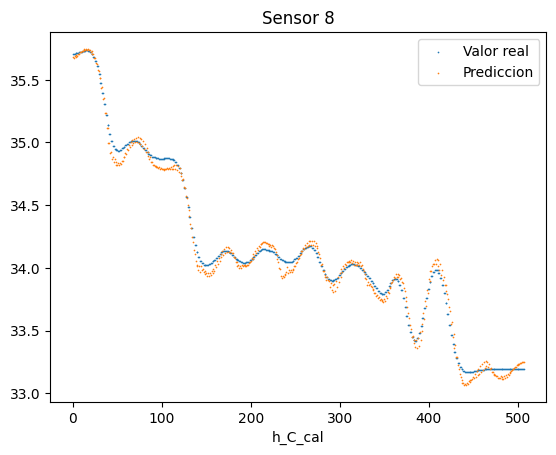

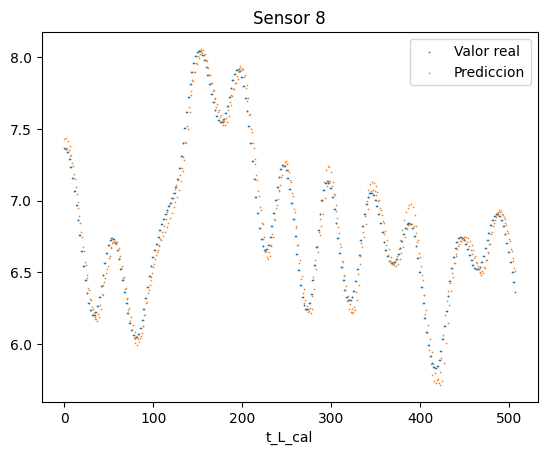

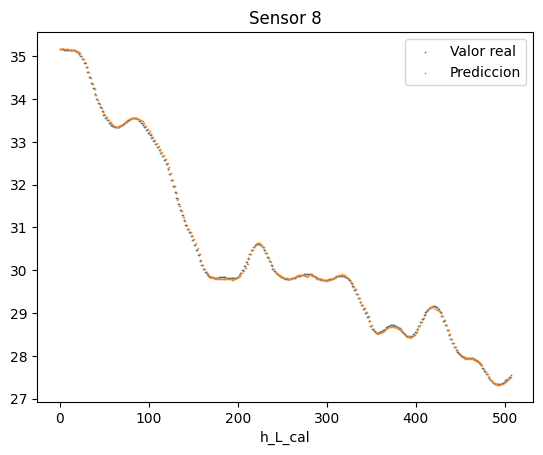

In [22]:
plot_results(targets, predictions, data_limits)

In [52]:
max_error(targets, predictions)

t_ext 0.9374020273825465
h_ext 0.9990778701721297
t_C_cal 0.8359501370733824
h_C_cal 1.2007865591025535
t_L_cal 0.5795118082631774
h_L_cal 0.4708054117892715


# LSTM

In [23]:
inputs = layers.Input(shape=X_train.shape[1:])
modelLSTM = layers.LSTM(32, return_sequences=True)(inputs)
modelLSTM = layers.LSTM(16, return_sequences=True)(modelLSTM)
modelLSTM = layers.LSTM(8)(modelLSTM)
modelLSTM = layers.Dense(y.shape[1] * y.shape[2])(modelLSTM)
outputs = layers.Reshape((y.shape[1], y.shape[2]))(modelLSTM)

modelLSTM = kr.Model(inputs=inputs, outputs=outputs)
# ch_callback = kr.callbacks.ModelCheckpoint(filepath="./tmp/checkpoint", monitor="val_loss", save_best_only=True, mode="min", verbose=)
modelLSTM.compile(loss="mse", optimizer=get_optimizer())
modelLSTM.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 6, 32)             4992      
                                                                 
 lstm_1 (LSTM)               (None, 6, 16)             3136      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 reshape_1 (Reshape)         (None, 2, 6)              0         
                                                                 
Total params: 9,036
Trainable params: 9,036
Non-trainable p

In [24]:
# Entrenamiento de la RNA
history = modelLSTM.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[get_scheduler()], workers=10)

Epoch 1/100
176/176 [==============================] - 17s 31ms/step - loss: 0.0217 - val_loss: 0.0036 - lr: 0.0100
Epoch 2/100
176/176 [==============================] - 3s 17ms/step - loss: 0.0022 - val_loss: 0.0017 - lr: 0.0100
Epoch 3/100
176/176 [==============================] - 3s 19ms/step - loss: 9.1903e-04 - val_loss: 4.3825e-04 - lr: 0.0100
Epoch 4/100
176/176 [==============================] - 3s 19ms/step - loss: 2.9097e-04 - val_loss: 2.9538e-04 - lr: 0.0100
Epoch 5/100
176/176 [==============================] - 3s 18ms/step - loss: 2.3498e-04 - val_loss: 2.8649e-04 - lr: 0.0100
Epoch 6/100
176/176 [==============================] - 3s 19ms/step - loss: 2.1598e-04 - val_loss: 2.8463e-04 - lr: 0.0100
Epoch 7/100
176/176 [==============================] - 3s 18ms/step - loss: 2.0630e-04 - val_loss: 2.4677e-04 - lr: 0.0100
Epoch 8/100
176/176 [==============================] - 3s 18ms/step - loss: 1.8508e-04 - val_loss: 2.2095e-04 - lr: 0.0100
Epoch 9/100
176/176 [==========

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

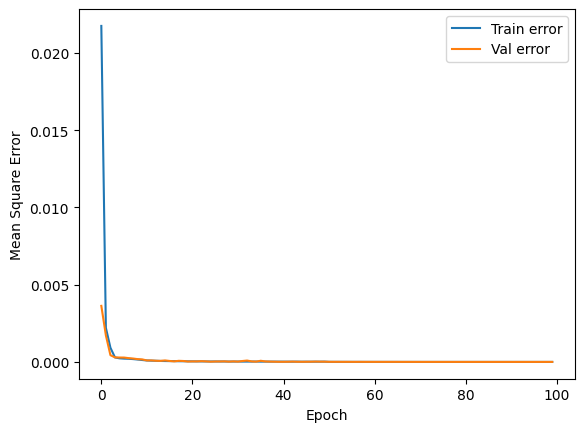

In [26]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [27]:
predictions = get_predictions(modelLSTM, X_test)

188/188 [==============================] - 3s 4ms/step


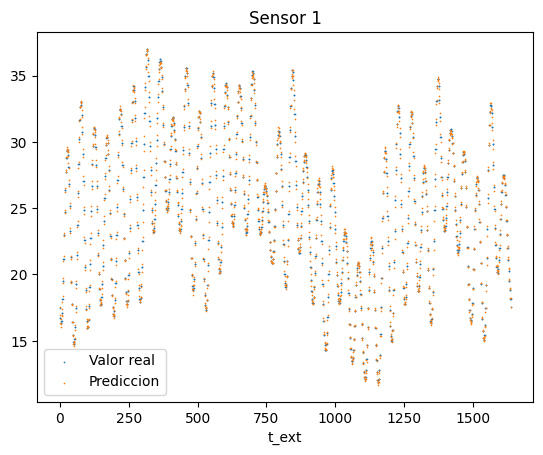

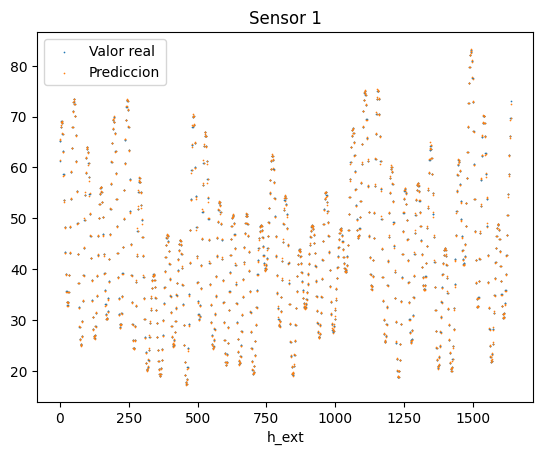

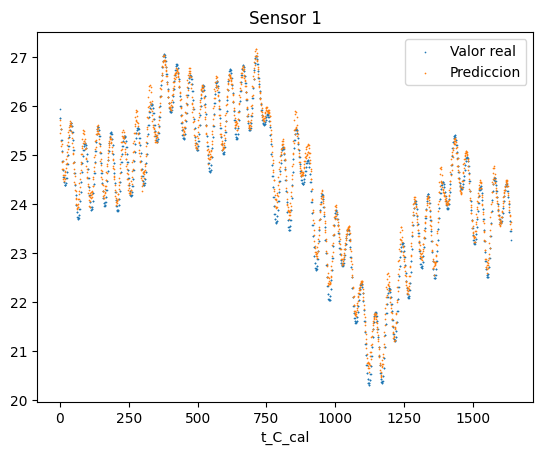

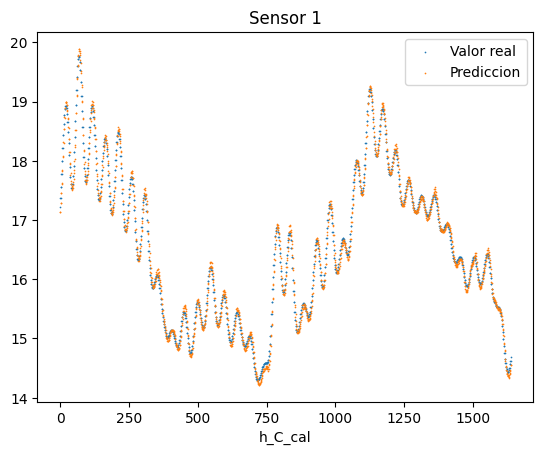

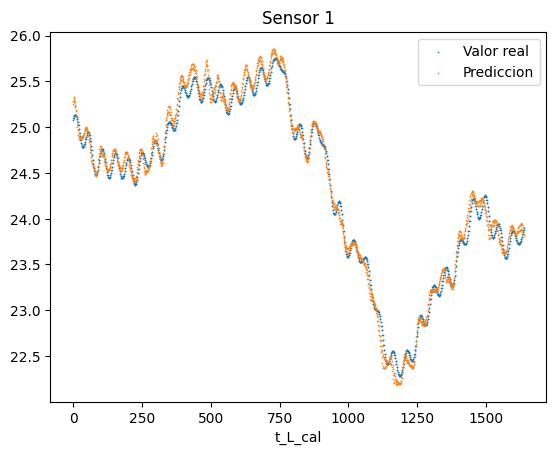

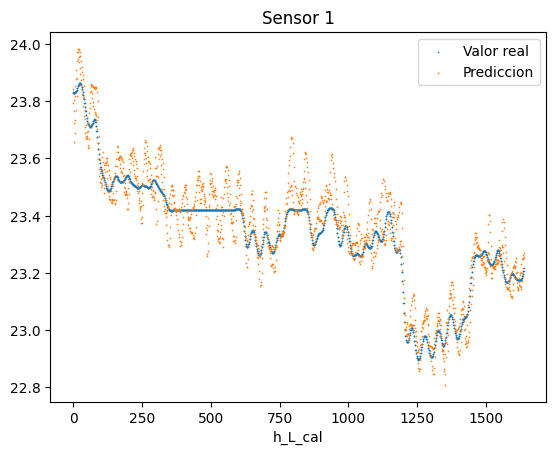

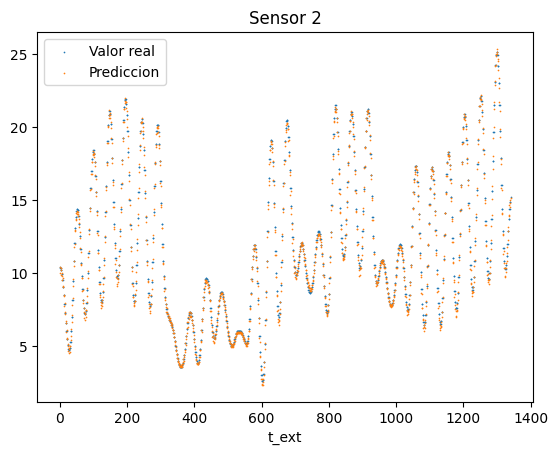

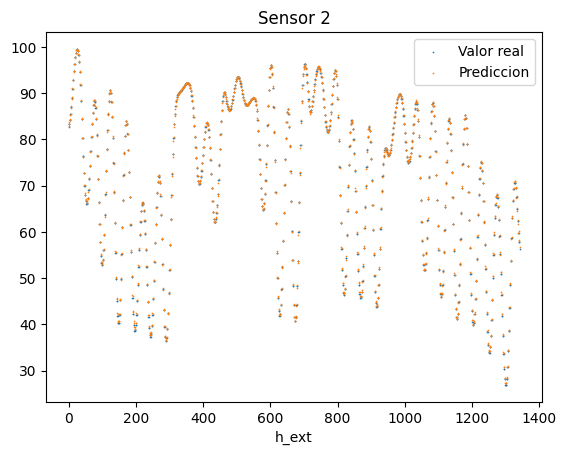

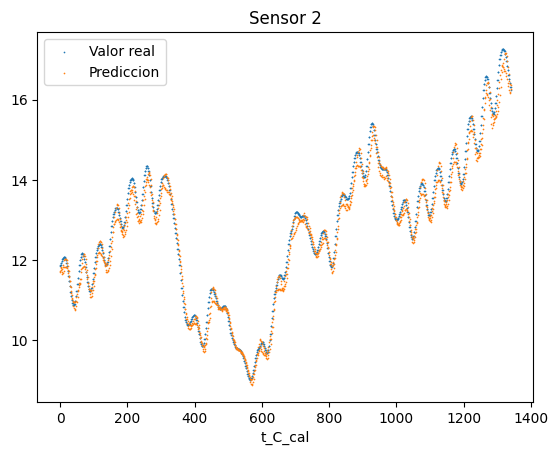

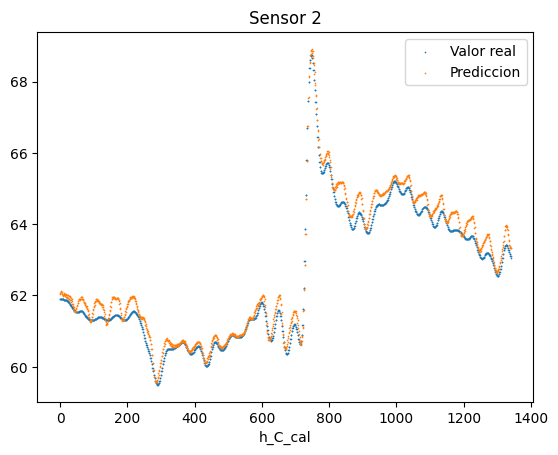

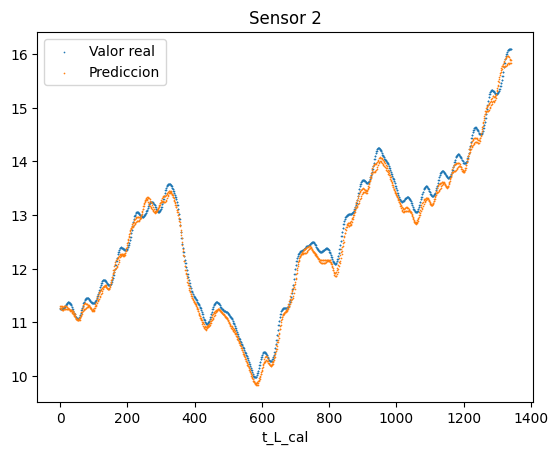

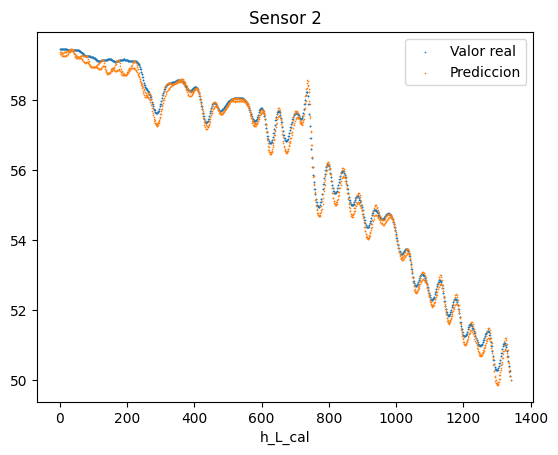

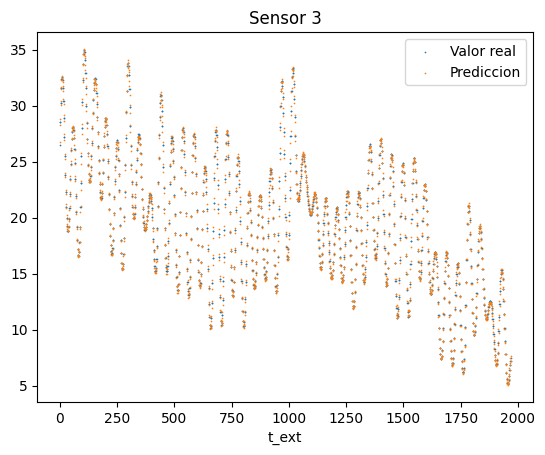

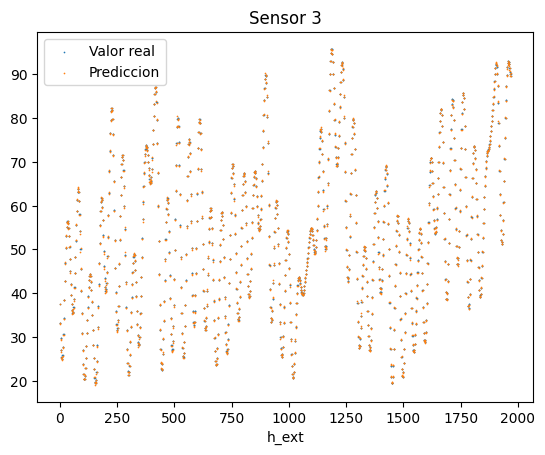

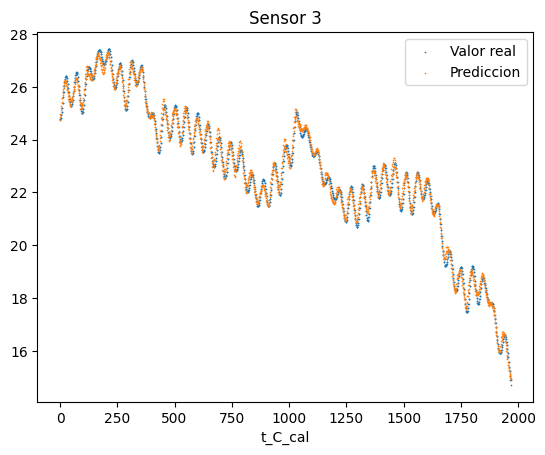

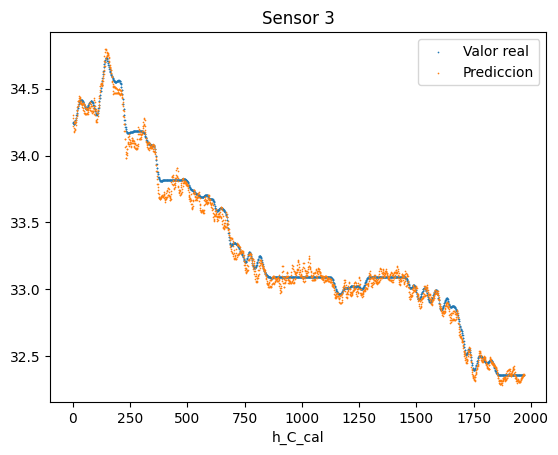

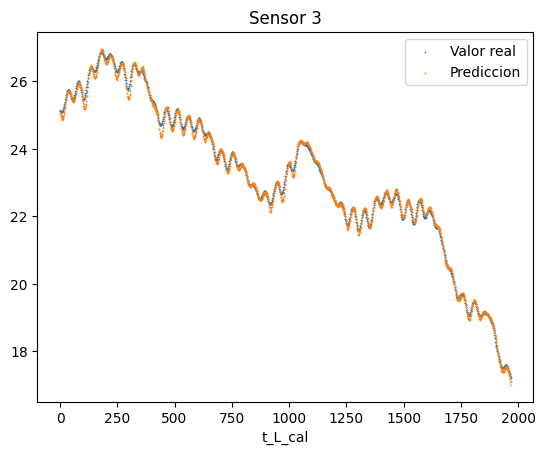

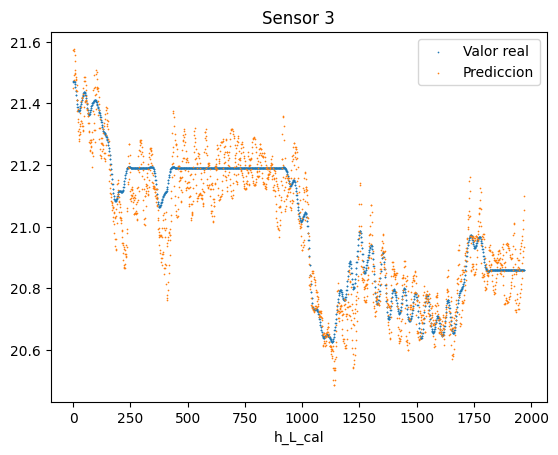

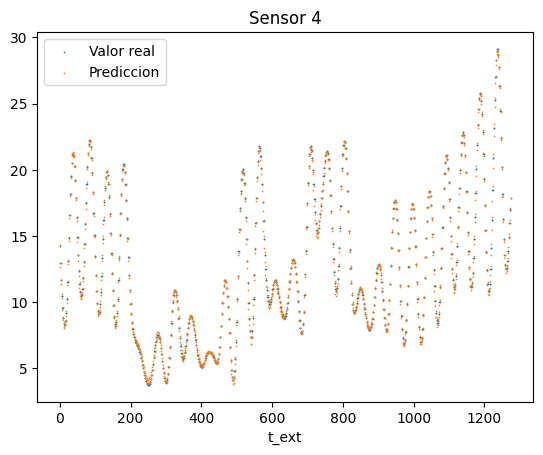

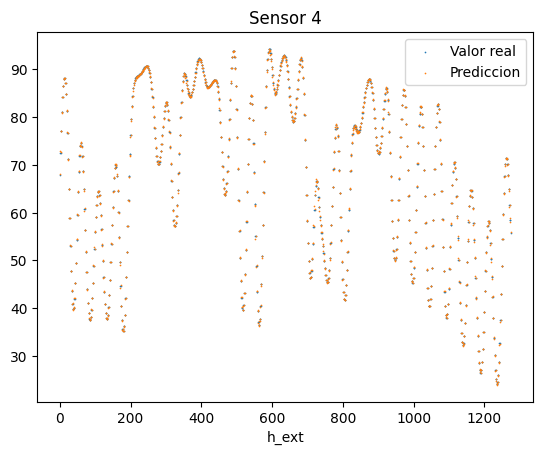

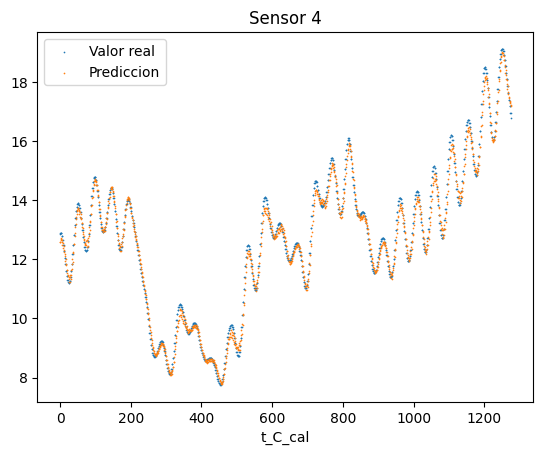

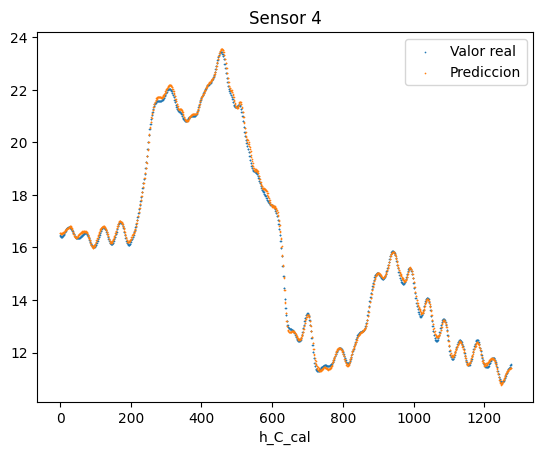

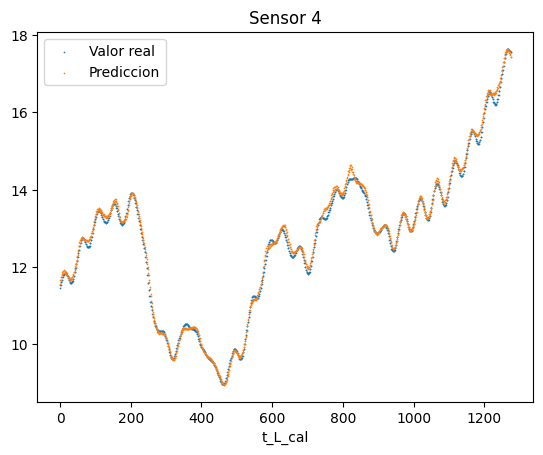

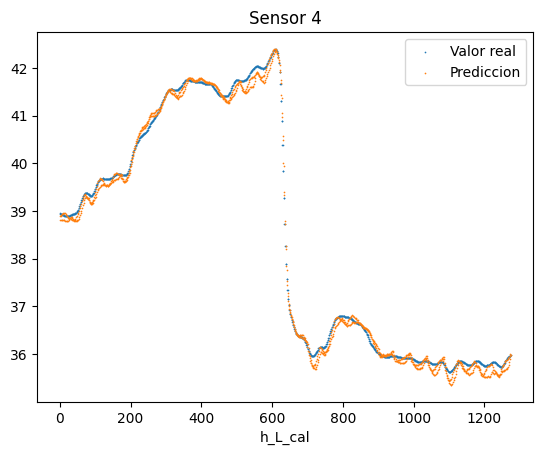

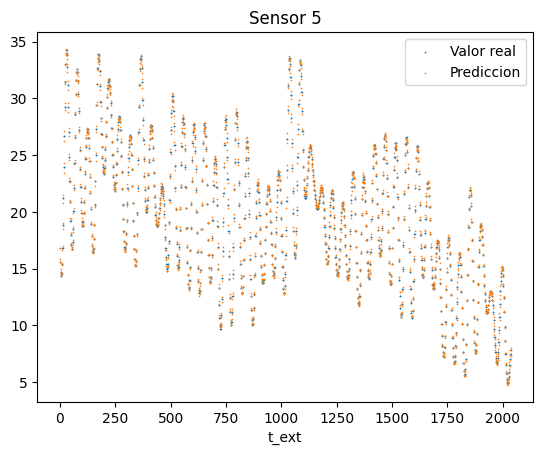

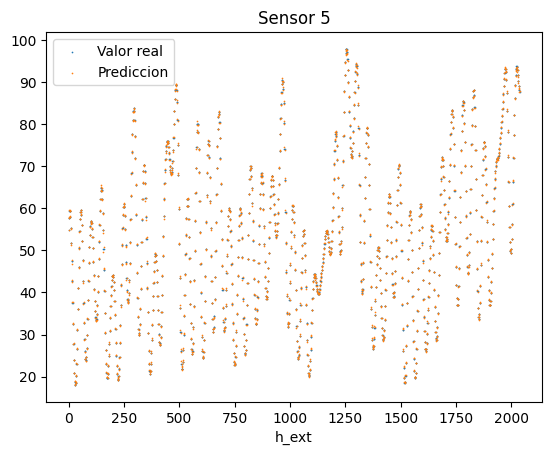

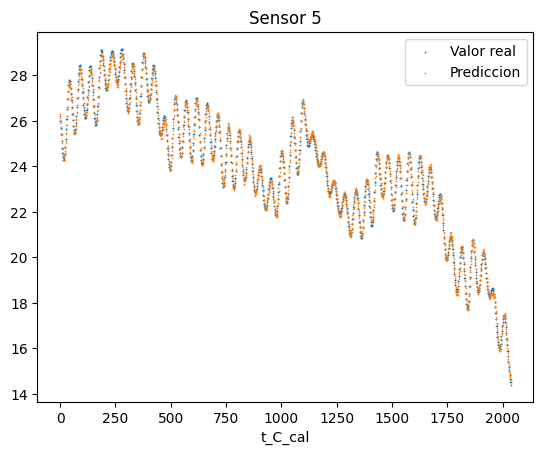

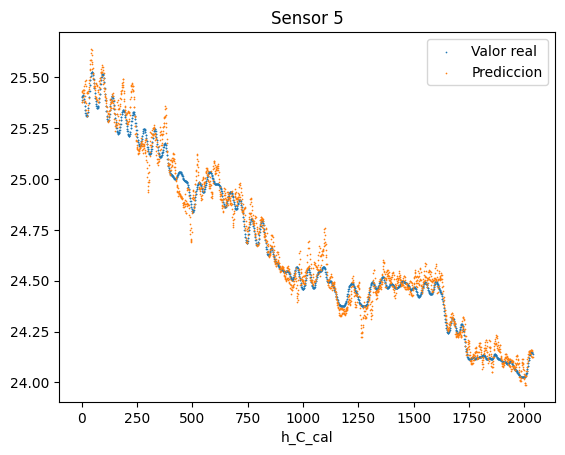

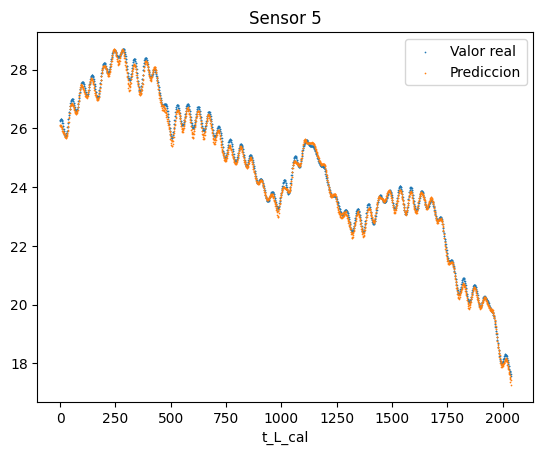

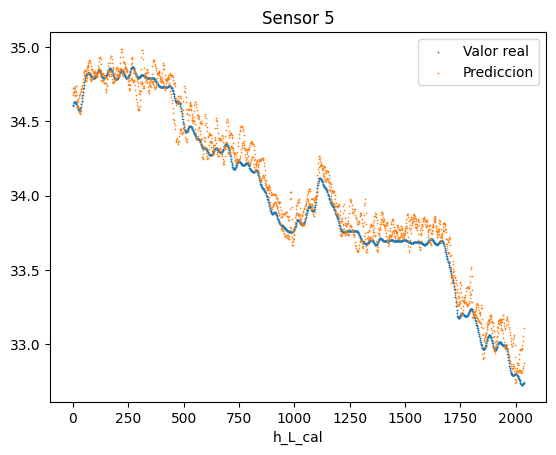

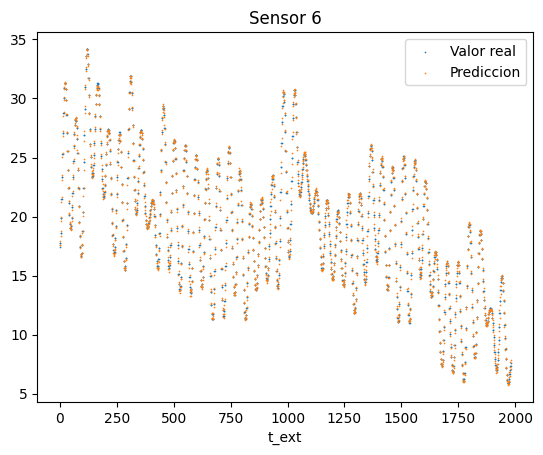

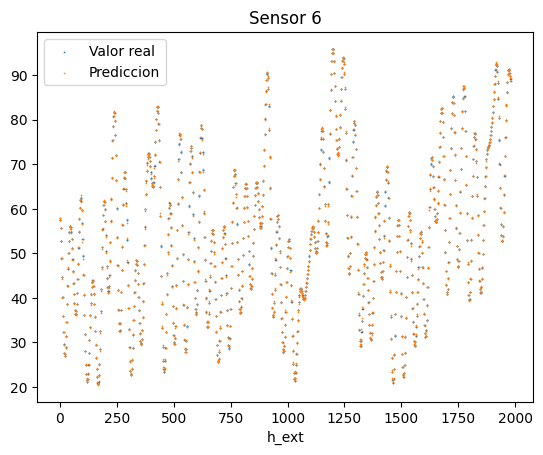

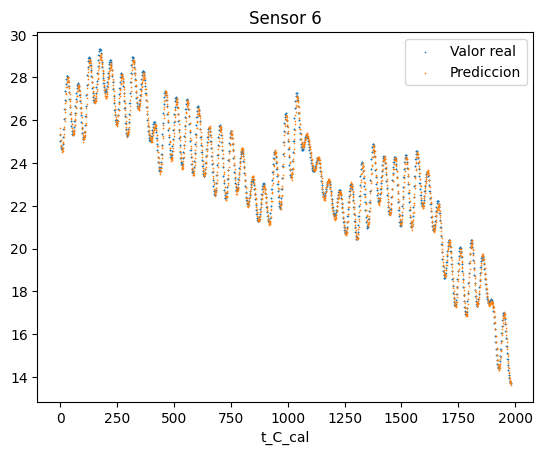

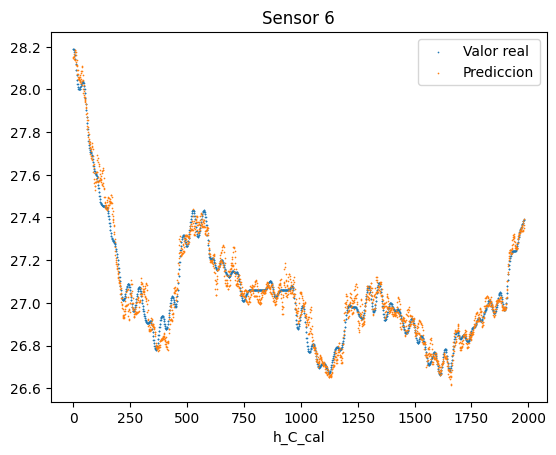

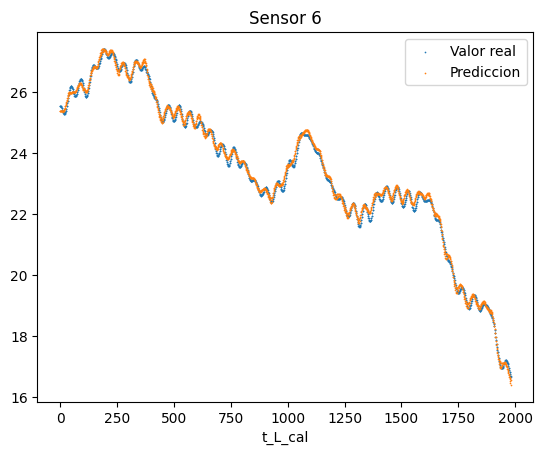

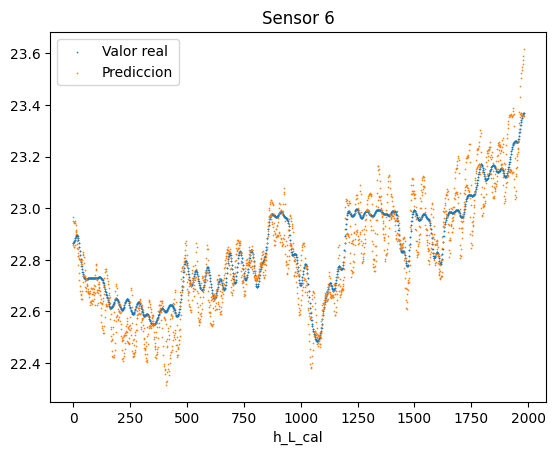

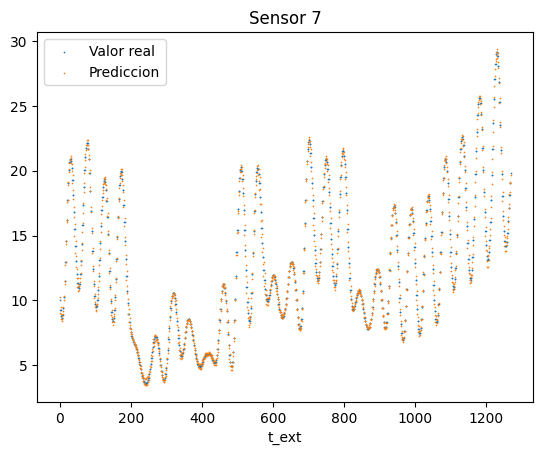

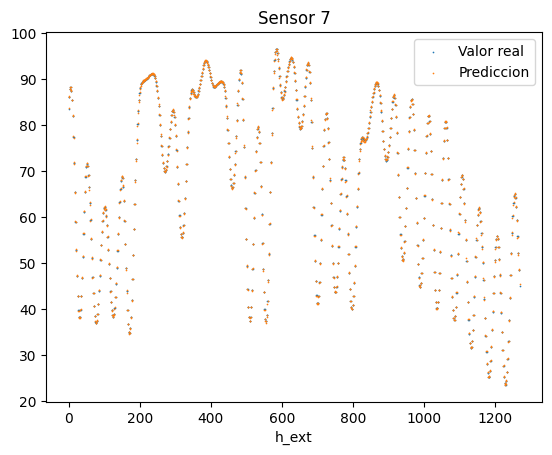

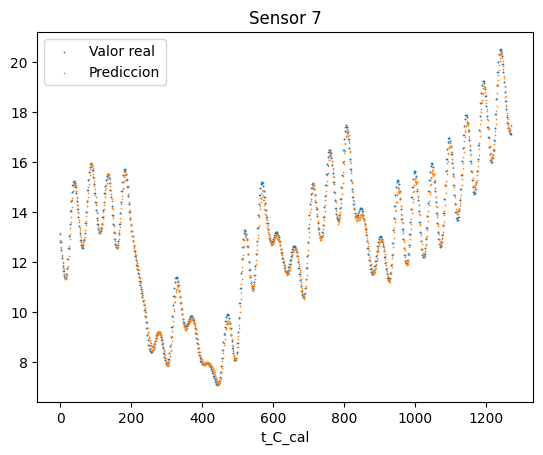

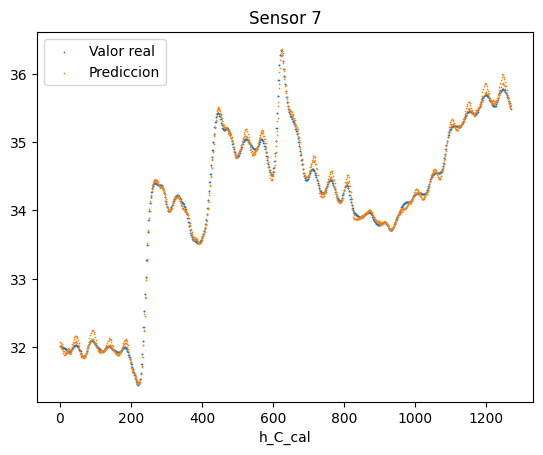

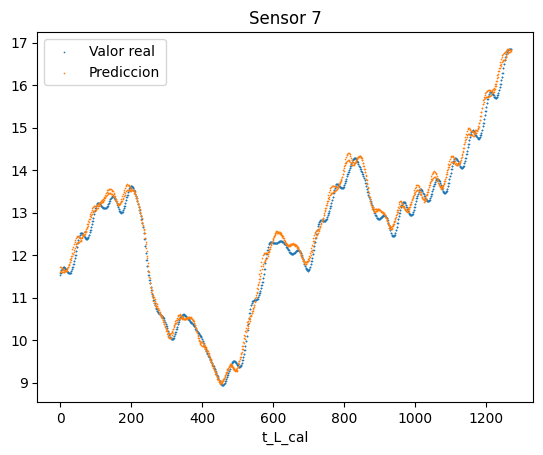

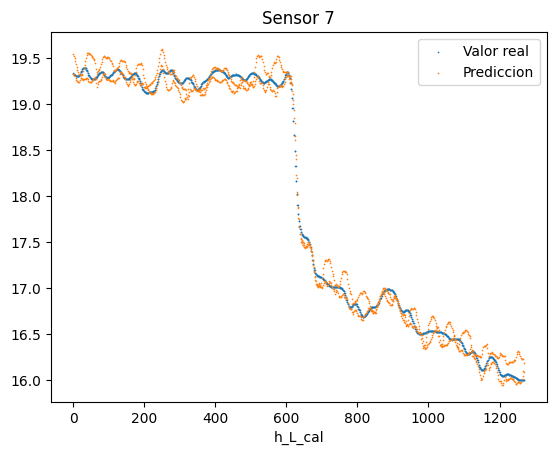

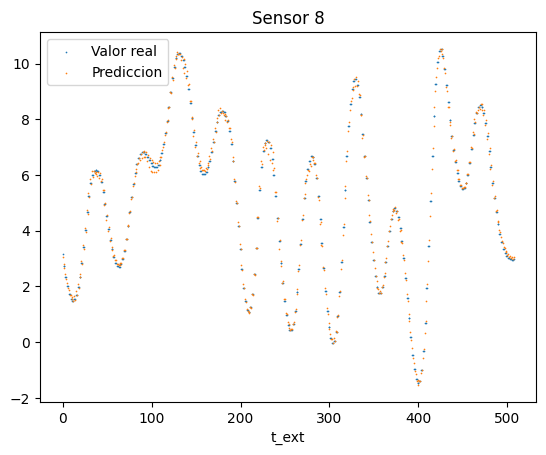

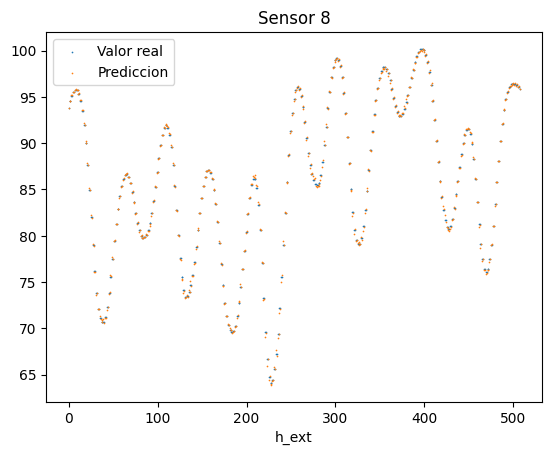

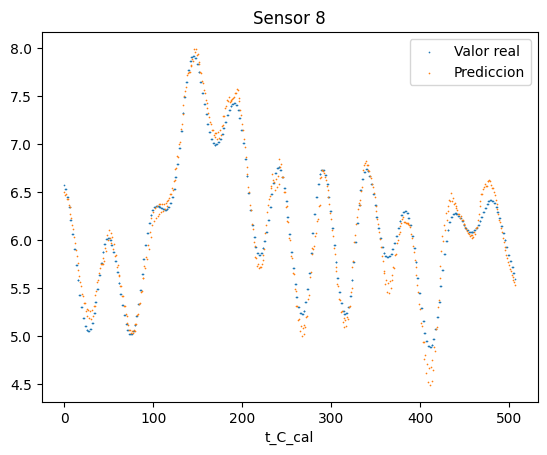

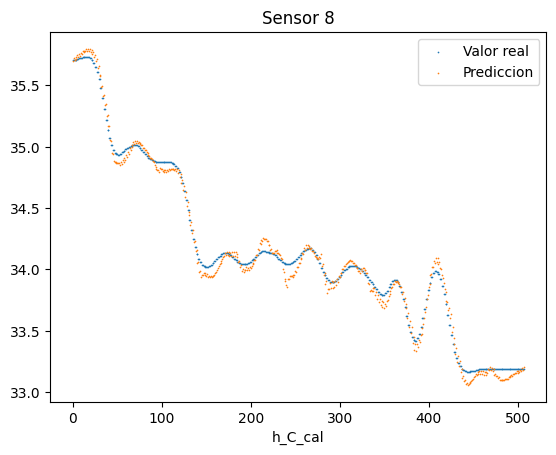

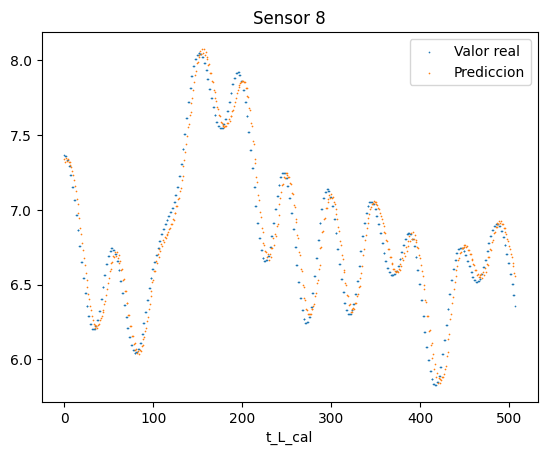

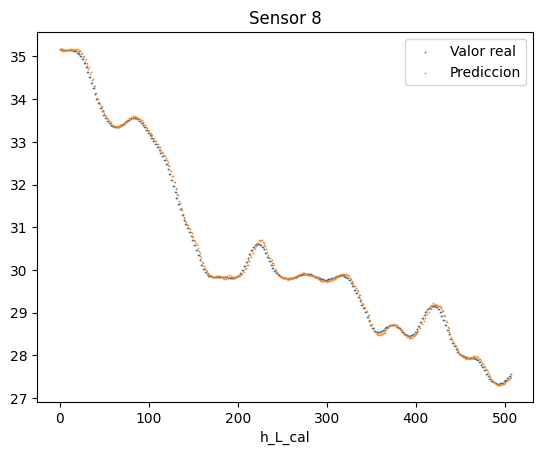

In [28]:
plot_results(targets, predictions, data_limits)

In [29]:
max_error(targets, predictions)

t_ext 0.902397627917594
h_ext 0.8559141853586212
t_C_cal 1.03229342257994
h_C_cal 1.1110877675986472
t_L_cal 0.5549960181017681
h_L_cal 0.6716557946790758


# MLP

In [30]:
# Modificamos los tensores de entrada transformandoles en vectores de entrada, para que pueden ser empleados por la MLP
X_train_mlp = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_val_mlp = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))

inputs = layers.Input(shape=X_train_mlp.shape[1:])
modelMLP = layers.Dense(32)(inputs)
modelMLP = layers.Dense(16)(modelMLP)
modelMLP = layers.Dense(8)(modelMLP)
modelMLP = layers.Dense(y.shape[1] * y.shape[2])(modelMLP)
outputs = layers.Reshape((y.shape[1], y.shape[2]))(modelMLP)

modelMLP = kr.Model(inputs=inputs, outputs=outputs)
modelMLP.compile(loss="mse", optimizer=get_optimizer())
modelMLP.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense_2 (Dense)             (None, 32)                1184      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 12)                108       
                                                                 
 reshape_2 (Reshape)         (None, 2, 6)              0         
                                                                 
Total params: 1,956
Trainable params: 1,956
Non-trainable p

In [31]:
history = modelMLP.fit(x=X_train_mlp, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val_mlp, y_val), callbacks=[get_scheduler()], workers=10)

Epoch 1/100
176/176 [==============================] - 2s 4ms/step - loss: 0.0224 - val_loss: 0.0015 - lr: 0.0100
Epoch 2/100
176/176 [==============================] - 0s 3ms/step - loss: 9.5463e-04 - val_loss: 7.0726e-04 - lr: 0.0100
Epoch 3/100
176/176 [==============================] - 0s 3ms/step - loss: 4.1275e-04 - val_loss: 2.9863e-04 - lr: 0.0100
Epoch 4/100
176/176 [==============================] - 0s 3ms/step - loss: 2.6187e-04 - val_loss: 2.5881e-04 - lr: 0.0100
Epoch 5/100
176/176 [==============================] - 0s 3ms/step - loss: 2.3228e-04 - val_loss: 2.2089e-04 - lr: 0.0100
Epoch 6/100
176/176 [==============================] - 0s 3ms/step - loss: 2.3206e-04 - val_loss: 1.7796e-04 - lr: 0.0100
Epoch 7/100
176/176 [==============================] - 0s 3ms/step - loss: 1.9653e-04 - val_loss: 2.1728e-04 - lr: 0.0100
Epoch 8/100
176/176 [==============================] - 0s 3ms/step - loss: 1.8760e-04 - val_loss: 2.0423e-04 - lr: 0.0100
Epoch 9/100
176/176 [===========

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

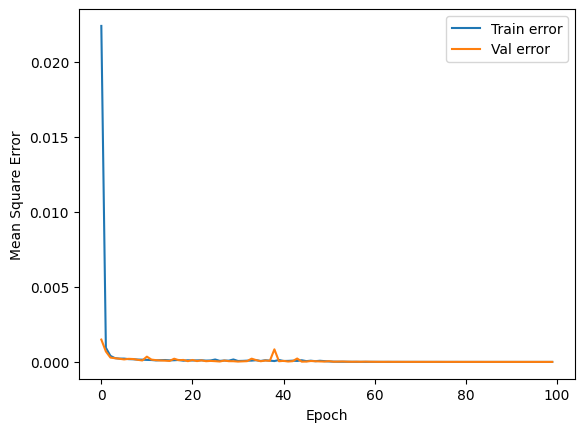

In [33]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [34]:
predictions = get_predictions(modelMLP, X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2])))

188/188 [==============================] - 0s 2ms/step


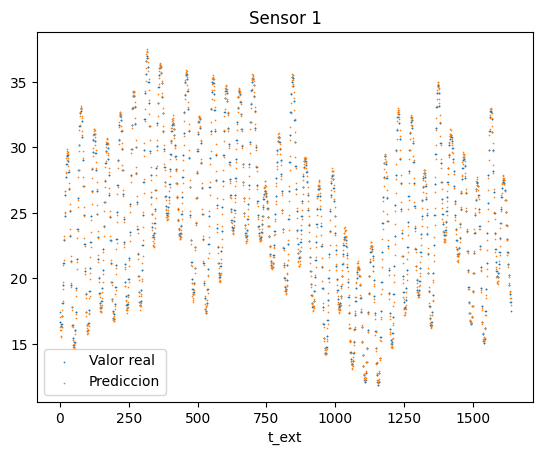

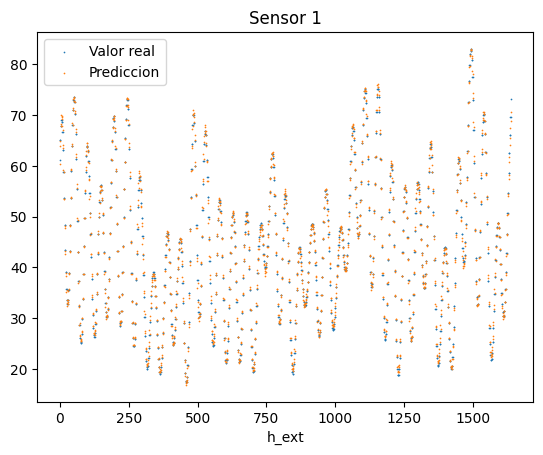

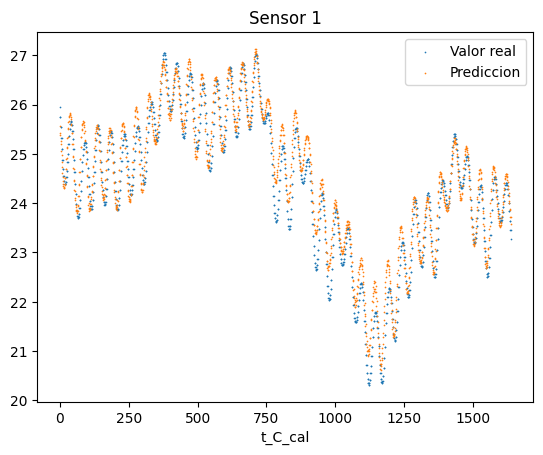

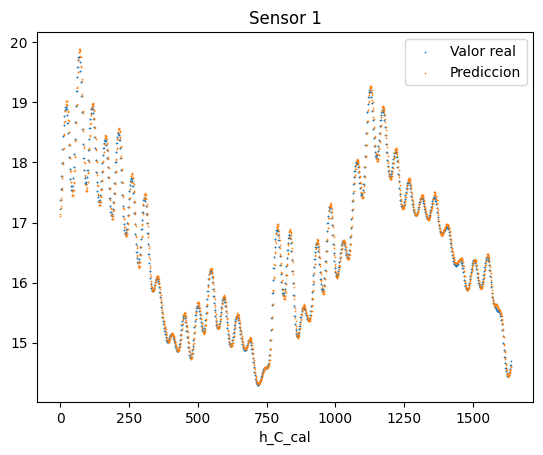

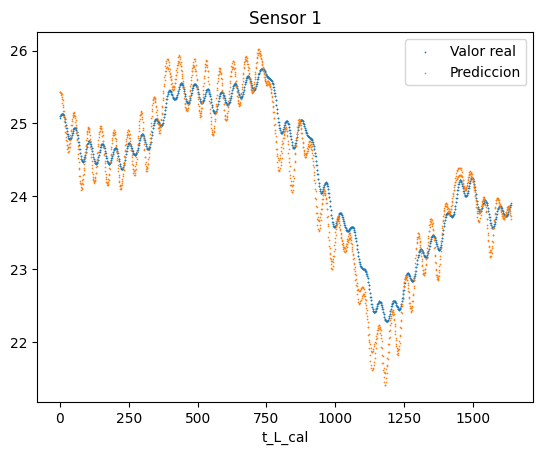

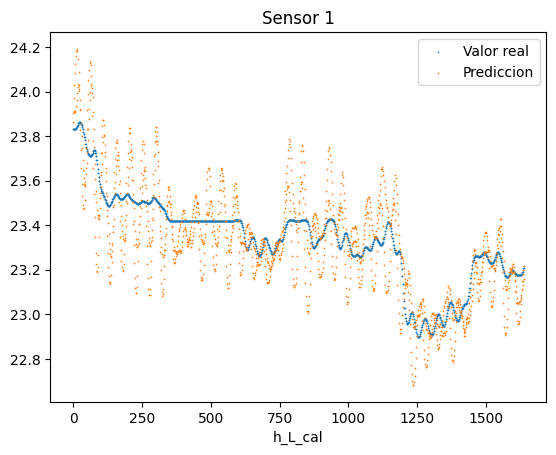

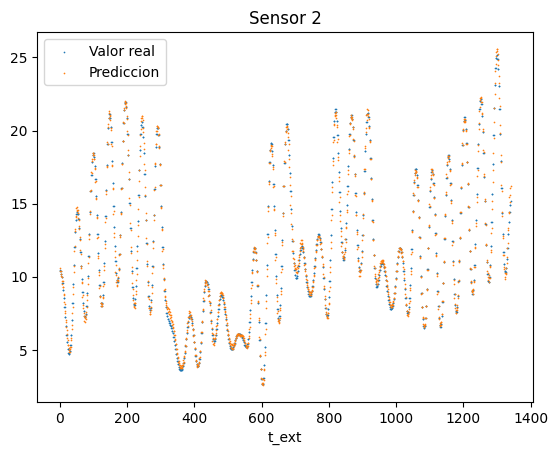

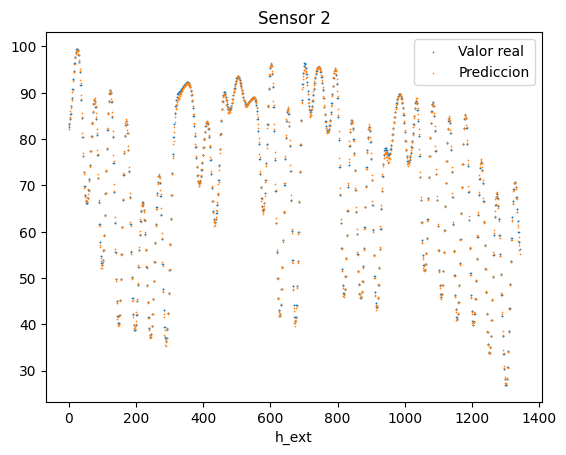

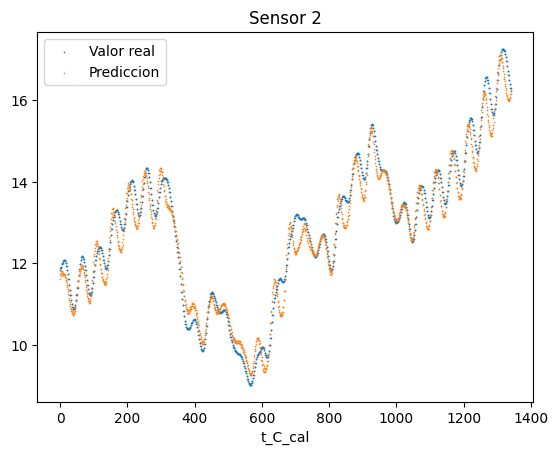

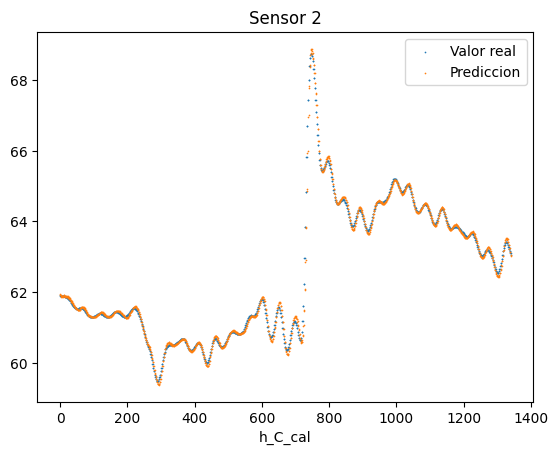

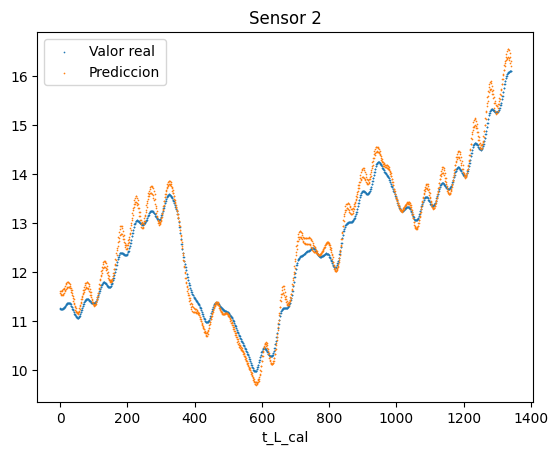

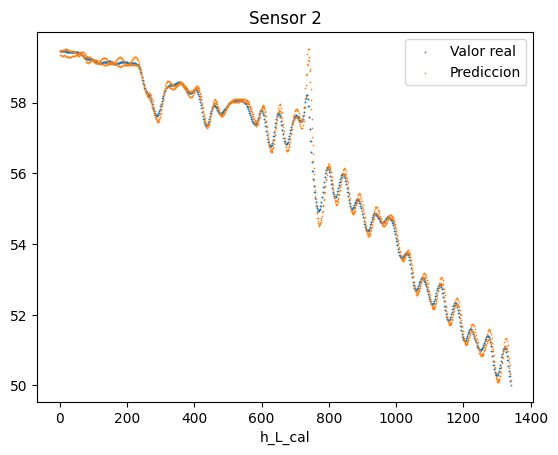

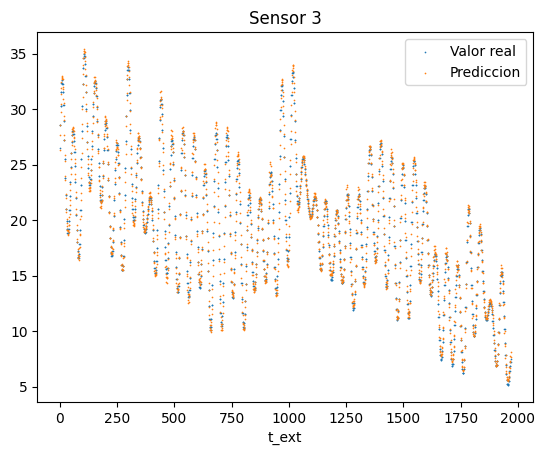

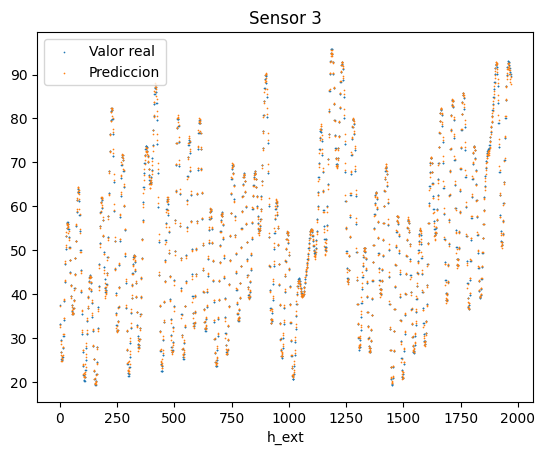

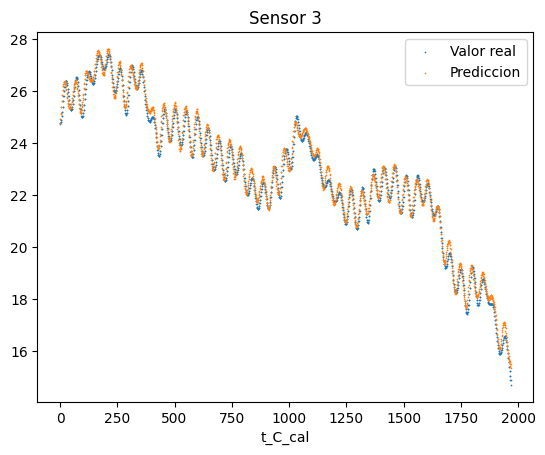

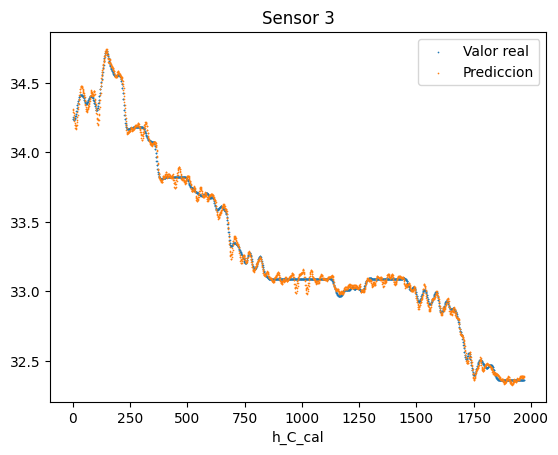

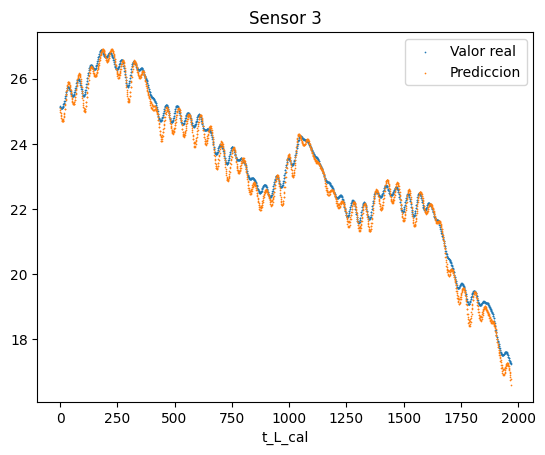

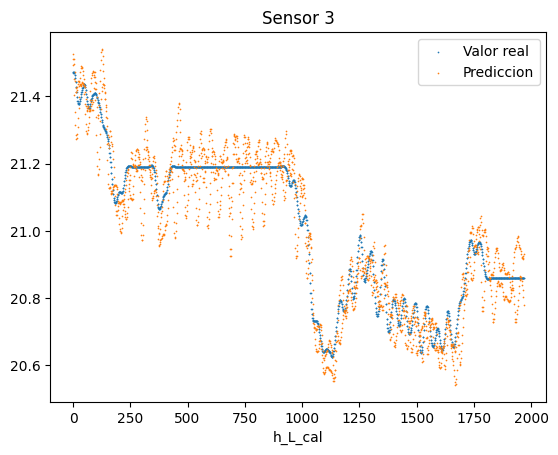

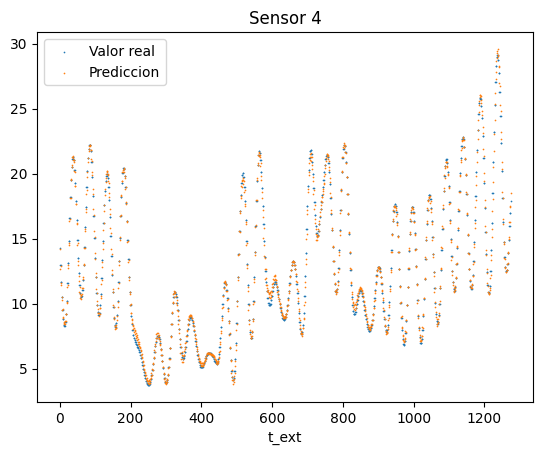

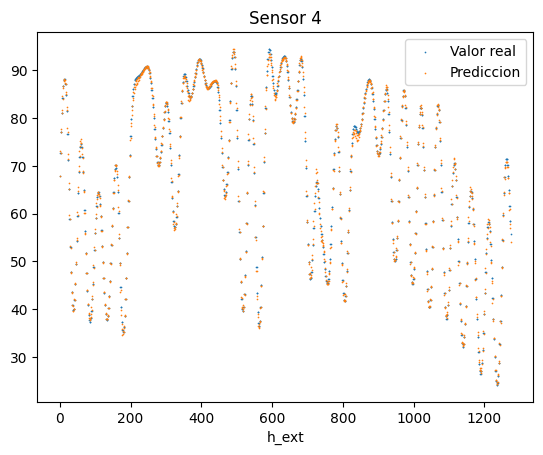

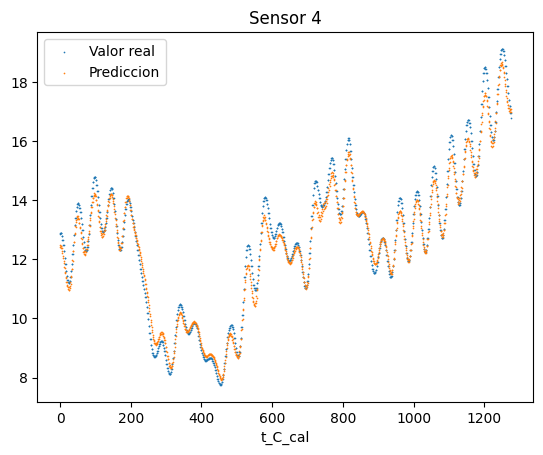

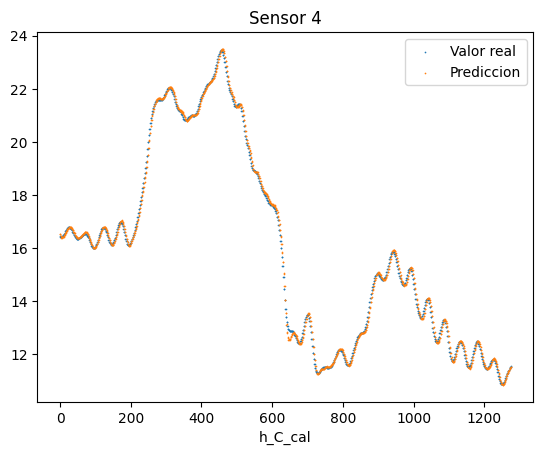

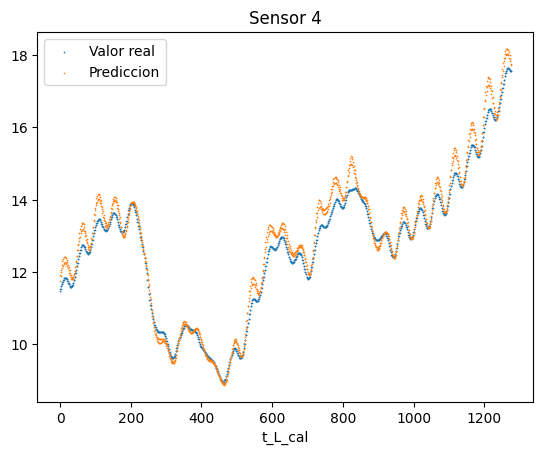

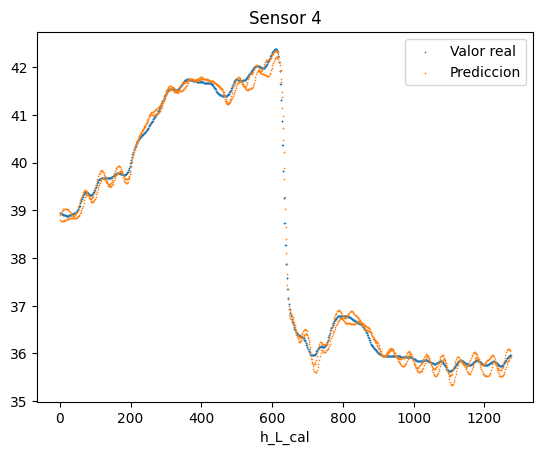

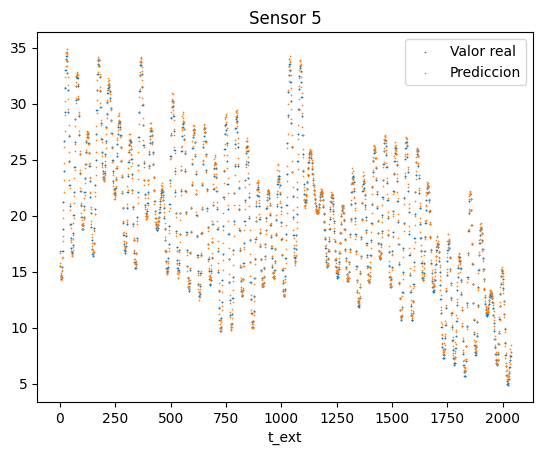

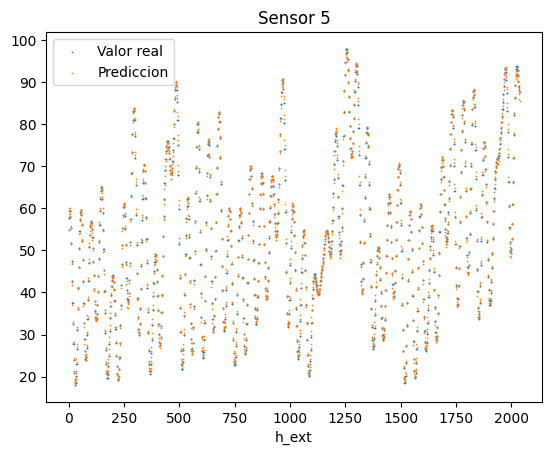

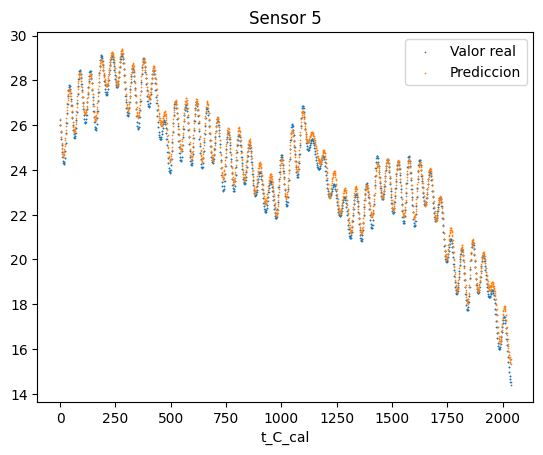

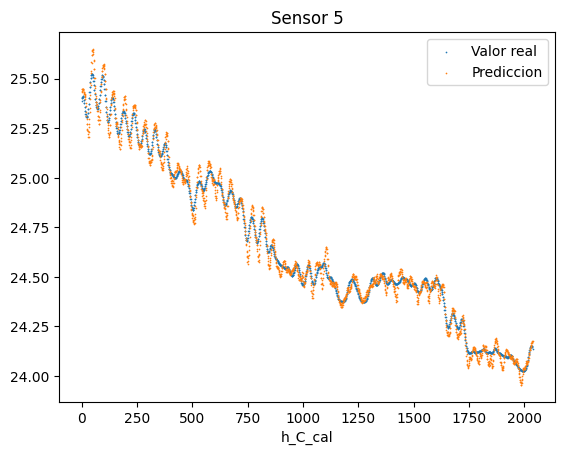

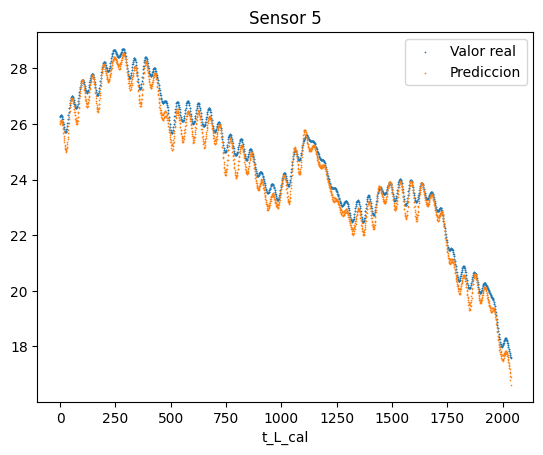

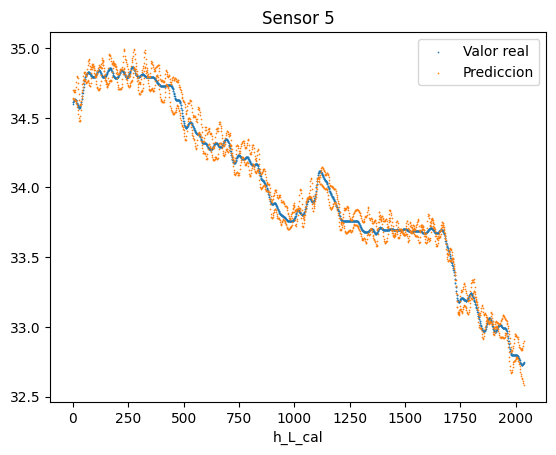

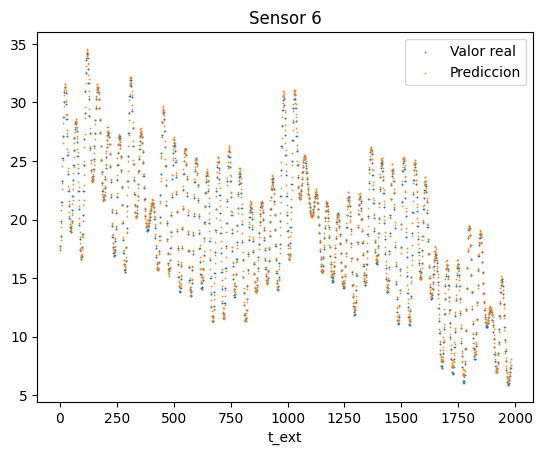

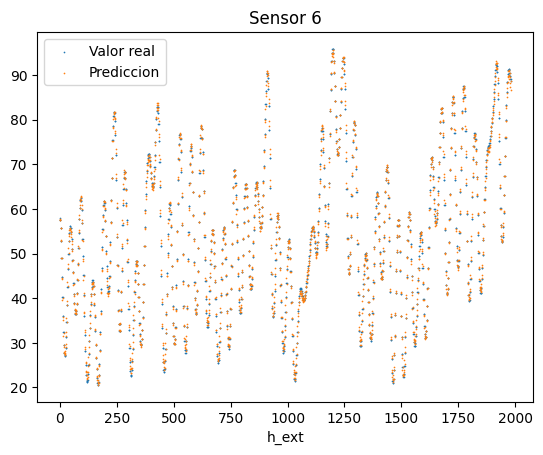

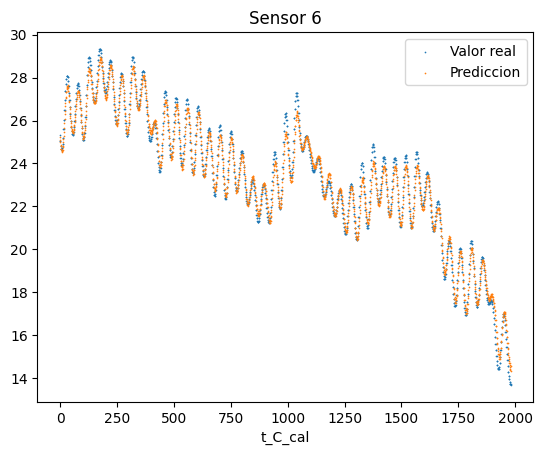

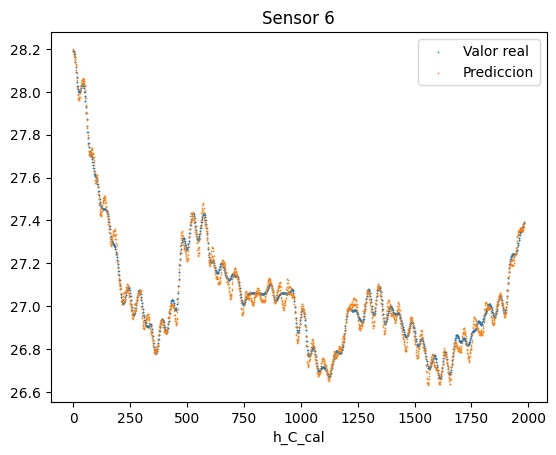

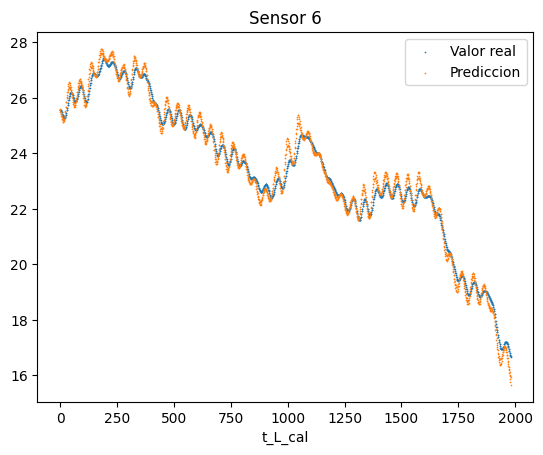

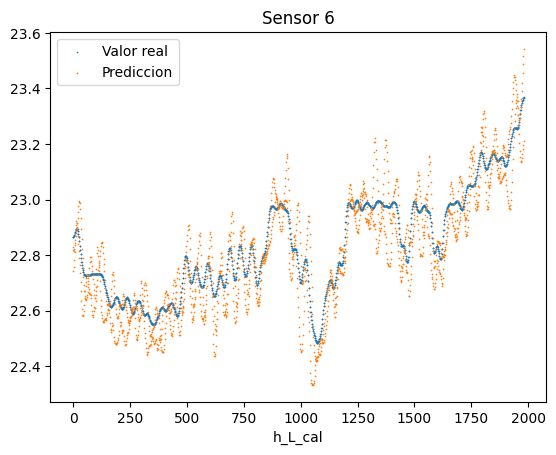

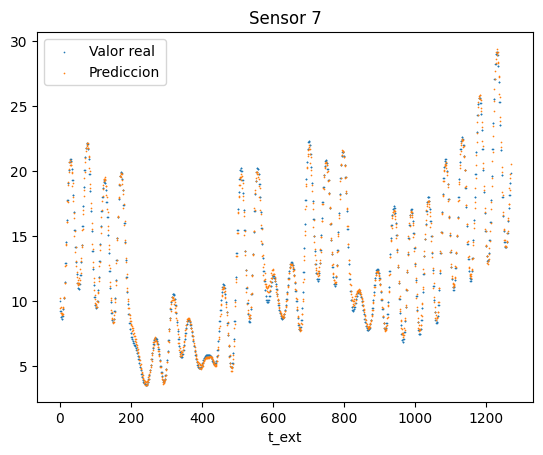

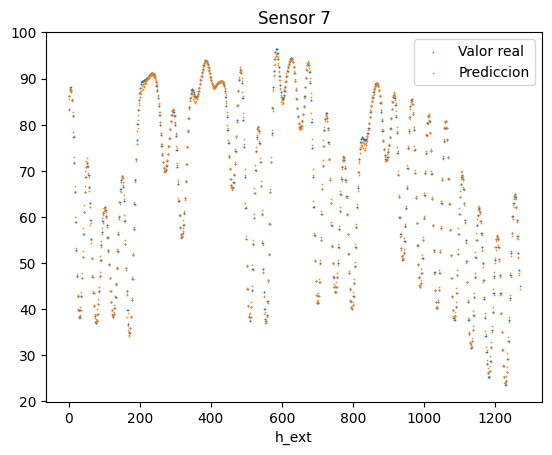

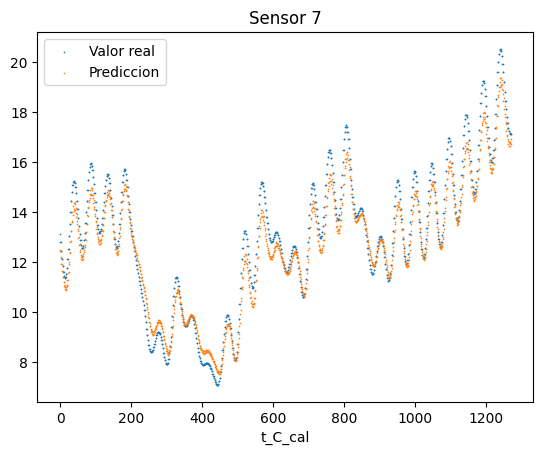

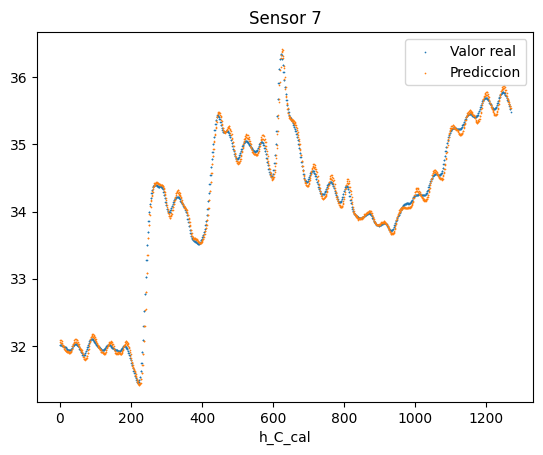

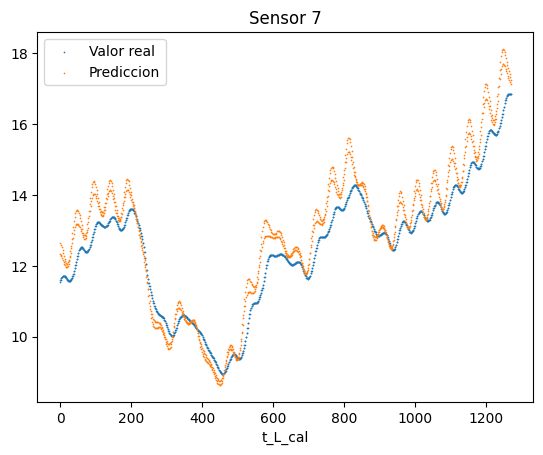

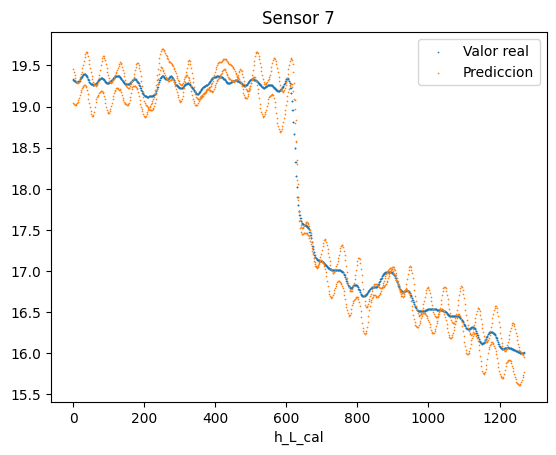

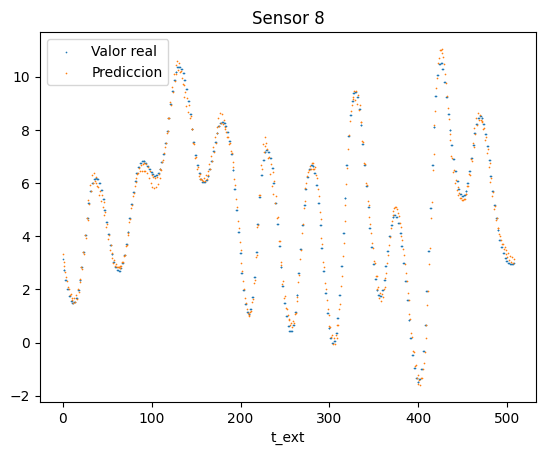

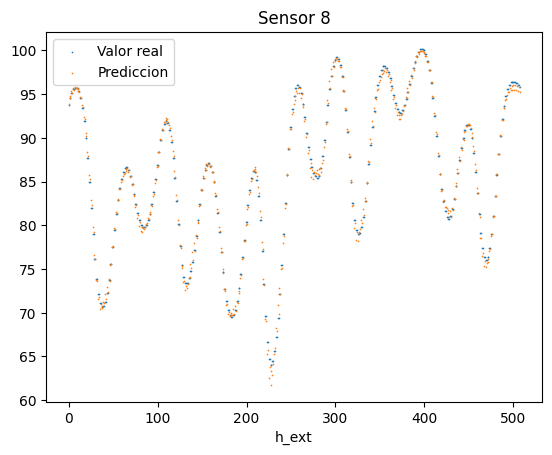

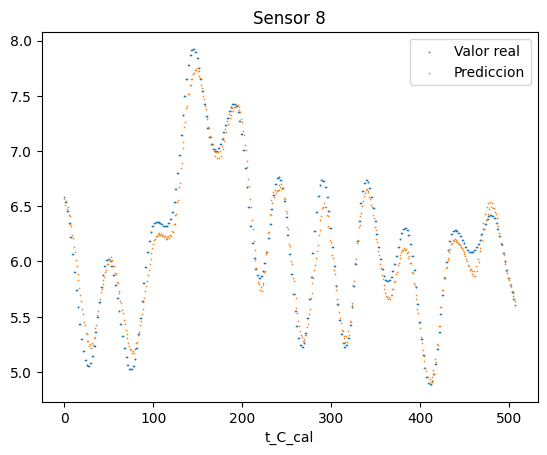

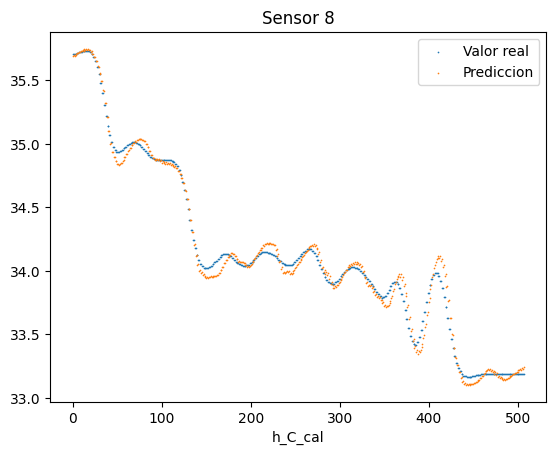

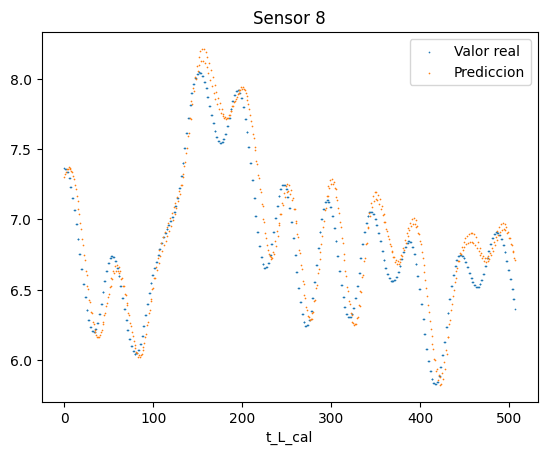

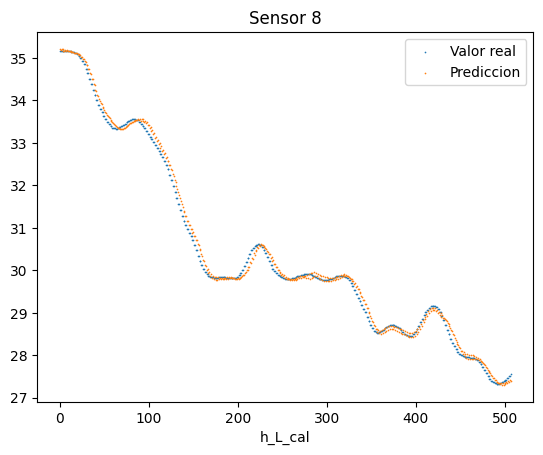

In [35]:
plot_results(targets, predictions, data_limits)

In [36]:
max_error(targets, predictions)

t_ext 2.298019126965329
h_ext 2.772420726490921
t_C_cal 1.5911921219962295
h_C_cal 1.9571380300498191
t_L_cal 1.8330355133134333
h_L_cal 1.6992681029635008


In [37]:
# model.save("./ann_model", overwrite=True)